In [1]:
%pip install neuralprophet

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.linear_model import LinearRegression
from prophet import Prophet
from neuralprophet import NeuralProphet
import optuna
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


In [3]:
# Load and preprocess data
df = pd.read_csv('final_data.csv')
df['week_date'] = pd.to_datetime(df['week_date'], format='%d/%m/%Y')
df.set_index('week_date', inplace=True)
df.head()

,total_sales,cost_iron,cost_aluminum,cost_energy,fx_rate,ev_sales
week_date,,,,,,
2020-12-28,10932394,1.39,1645.84,0.0676,1.2271,79409
2021-01-04,3686280,1.39,1645.84,0.0676,1.2296,79409
2021-01-11,8965000,1.39,1645.84,0.0676,1.2163,79409
2021-01-18,11766983,1.39,1645.84,0.0676,1.2064,79409
2021-01-25,4926779,1.39,1645.84,0.0676,1.2152,79409


In [4]:
# Create interaction terms
df['cost_iron_fx'] = df['cost_iron'] * df['fx_rate']
df['cost_aluminum_fx'] = df['cost_aluminum'] * df['fx_rate']
df['cost_energy_fx'] = df['cost_energy'] * df['fx_rate']
df['ev_sales_fx'] = df['ev_sales'] * df['fx_rate']
df.head()

,total_sales,cost_iron,cost_aluminum,cost_energy,fx_rate,ev_sales,cost_iron_fx,cost_aluminum_fx,cost_energy_fx,ev_sales_fx
week_date,,,,,,,,,,
2020-12-28,10932394,1.39,1645.84,0.0676,1.2271,79409,1.705669,2019.610264,0.082952,97442.7839
2021-01-04,3686280,1.39,1645.84,0.0676,1.2296,79409,1.709144,2023.724864,0.083121,97641.3064
2021-01-11,8965000,1.39,1645.84,0.0676,1.2163,79409,1.690657,2001.835192,0.082222,96585.1667
2021-01-18,11766983,1.39,1645.84,0.0676,1.2064,79409,1.676896,1985.541376,0.081553,95799.0176
2021-01-25,4926779,1.39,1645.84,0.0676,1.2152,79409,1.689128,2000.024768,0.082148,96497.8168


In [5]:
# Split into train and test
train_df = df.loc[:'2024-06-24']
test_df = df.loc['2024-07-01':]  # Ensure test starts from 2024-07-01
exog_cols = ['cost_iron', 'cost_aluminum', 'cost_energy', 'fx_rate', 'ev_sales',
             'cost_iron_fx', 'cost_aluminum_fx', 'cost_energy_fx', 'ev_sales_fx']
target_col = 'total_sales'

train_y = train_df[target_col]
train_exog = train_df[exog_cols]
test_y = test_df[target_col]
test_exog = test_df[exog_cols]

# Prepare Prophet and NP compatible data (only accepts ds as date and y as target)
train_prophet = train_df.reset_index().rename(columns={'week_date': 'ds', target_col: 'y'})
test_prophet = test_df.reset_index().rename(columns={'week_date': 'ds', target_col: 'y'})

In [6]:
# Standard scale exogenous variables
scaler = StandardScaler()
train_exog_scaled = pd.DataFrame(
    scaler.fit_transform(train_exog),
    columns=train_exog.columns,
    index=train_exog.index
)
test_exog_scaled = pd.DataFrame(
    scaler.transform(test_exog),
    columns=test_exog.columns,
    index=test_exog.index
)

In [7]:
# Create train_np and test_np as copies of train_prophet and test_prophet, but with exogenous columns scaled
train_np = train_prophet.copy()
test_np = test_prophet.copy()

for col in exog_cols:
    train_np[col] = train_exog_scaled[col].values
    test_np[col] = test_exog_scaled[col].values

train_np.head()

,ds,y,cost_iron,cost_aluminum,cost_energy,fx_rate,ev_sales,cost_iron_fx,cost_aluminum_fx,cost_energy_fx,ev_sales_fx
0,2020-12-28,10932394,0.917814,-1.915154,-1.679787,2.005902,-1.69973,1.267883,-1.336065,-1.672919,-1.601274
1,2021-01-04,3686280,0.917814,-1.915154,-1.679787,2.046410,-1.69973,1.279360,-1.323531,-1.668335,-1.597710
2,2021-01-11,8965000,0.917814,-1.915154,-1.679787,1.830907,-1.69973,1.218299,-1.390212,-1.692723,-1.616672
3,2021-01-18,11766983,0.917814,-1.915154,-1.679787,1.670495,-1.69973,1.172848,-1.439847,-1.710878,-1.630786
4,2021-01-25,4926779,0.917814,-1.915154,-1.679787,1.813083,-1.69973,1.213249,-1.395727,-1.694741,-1.618240


In [8]:
# Apply Box-Cox transformation to target
train_y_boxcox, boxcox_lambda = boxcox(train_y + 1)  # Add 1 to handle zero/negative values
test_y_boxcox = boxcox(test_y + 1, lmbda=boxcox_lambda)  # Transform test_y for consistency

In [9]:
# Define evaluation metrics function
def compute_metrics(actual, predicted):
    actual = np.array(actual)
    predicted = np.array(predicted)
    min_len = min(len(actual), len(predicted))
    actual = actual[:min_len]
    predicted = predicted[:min_len]
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    mape = np.mean(np.abs((actual - predicted) / (actual + np.finfo(float).eps))) * 100
    return rmse, mae, mape

In [10]:
# Store best parameters and forecasts
best_params = {}
forecasts = {}
metrics_dict = {}


Evaluation Metrics for baseline model:
RMSE: 5827717.50
MAE: 4739494.37
MAPE: 55.82%


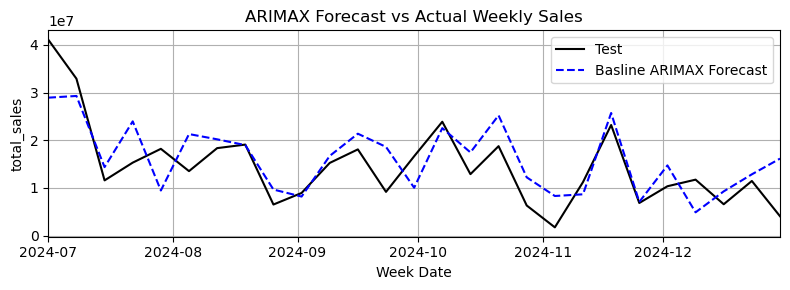

In [11]:
# Fit Baseline ARIMAX model
model = ARIMA(
    train_y_boxcox,
    exog=train_exog_scaled,
    order=(28, 0, 29)
)

results = model.fit()
forecast_boxcox = results.forecast(steps=len(test_y), exog=test_exog_scaled)
forecast = inv_boxcox(forecast_boxcox, boxcox_lambda) - 1

forecasts['Baseline'] = forecast
metrics_dict['Baseline'] = compute_metrics(test_y, forecast)

# Print evaluation metrics
rmse, mae, mape = metrics_dict['Baseline']
print("\nEvaluation Metrics for baseline model:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")


# Plotting
plt.figure(figsize=(8, 3))
plt.plot(test_y.index, test_y, label='Test', color='black')
plt.plot(test_y.index, forecast, label='Basline ARIMAX Forecast', linestyle='--', color='blue')
plt.legend()
plt.title('ARIMAX Forecast vs Actual Weekly Sales')
plt.xlabel('Week Date')
plt.ylabel(target_col)
plt.grid(True)
plt.xlim(pd.Timestamp('2024-07-01'), test_y.index[-1])
plt.tight_layout()
plt.show()

In [ ]:
# ARIMAX hyperparameter tuning
def arimax_objective(trial):
    p = trial.suggest_int('p', 1, 52)
    q = trial.suggest_int('q', 1, 52)
    try:
        model = ARIMA(train_y_boxcox, exog=train_exog_scaled, order=(p, 0, q))
        fit = model.fit()
        y_pred = fit.fittedvalues
        mse = np.mean((train_y_boxcox - y_pred) ** 2)
        return mse
    except:
        return float('inf')

# SARIMAX hyperparameter tuning
def sarimax_objective(trial):
    p = trial.suggest_int('p', 1, 7)
    q = trial.suggest_int('q', 1, 7)
    P = trial.suggest_int('P', 1, 7)
    Q = trial.suggest_int('Q', 1, 7)
    try:
        model = SARIMAX(
            train_y_boxcox,
            exog=train_exog_scaled,
            order=(p, 0, q),
            seasonal_order=(P, 1, Q, 52),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        fit = model.fit(disp=False)
        y_pred = fit.fittedvalues
        mse = np.mean((train_y_boxcox - y_pred) ** 2)
        return mse
    except:
        return float('inf')

# ETSX hyperparameter tuning
def etsx_objective(trial):
    error = trial.suggest_categorical('error', ['add', 'mul'])
    trend = trial.suggest_categorical('trend', ['add', 'mul'])
    damped_trend = trial.suggest_categorical('damped_trend', [True, False])
    seasonal = trial.suggest_categorical('seasonal', ['add', 'mul'])
    try:
        ets_model = ETSModel(
            train_y_boxcox,
            error=error,
            trend=trend,
            damped_trend=damped_trend,
            seasonal=seasonal,
            seasonal_periods=52
        )
        ets_fit = ets_model.fit()
        residuals = train_y_bocox - ets_fit.fittedvalues
        reg_model = LinearRegression()
        reg_model.fit(train_exog_scaled, residuals)
        y_pred = ets_fit.fittedvalues + reg_model.predict(train_exog_scaled)
        mse = np.mean((train_y_bocox - y_pred) ** 2)
        return mse
    except:
        return float('inf')
    
# Prophet hyperparameter tuning
def prophet_objective(trial):
    changepoint_prior_scale = trial.suggest_float('changepoint_prior_scale', 0.01, 1, log=True)
    n_changepoints = trial.suggest_int('n_changepoints', 10, 30)
    seasonality_prior_scale = trial.suggest_float('seasonality_prior_scale', 0.1, 20)
    seasonality_mode = trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative'])
    
    model = Prophet(
        changepoint_prior_scale=changepoint_prior_scale,
        n_changepoints=n_changepoints,
        seasonality_prior_scale=seasonality_prior_scale,
        seasonality_mode=seasonality_mode,
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False
    )

    model.add_country_holidays(country_name='US')
    
    for col in exog_cols:
        model.add_regressor(col)
    
    try:
        model.fit(train_prophet)
        train_forecast = model.predict(train_prophet[['ds'] + exog_cols])
        y_true = train_prophet['y'].values
        y_pred = train_forecast['yhat'].values
        mse = np.mean((y_true - y_pred) ** 2)
        return mse
    except Exception as e:
        print(f"Trial {trial.number} failed with error: {str(e)}")
        return float('inf')

# NeuralProphet hyperparameter tuning
def neuralprophet_objective(trial):
    n_ar_layers = trial.suggest_int('n_ar_layers', 1, 3)
    ar_layer_size = trial.suggest_categorical('ar_layer_size', [64, 128, 256])
    ar_layers = [ar_layer_size] * n_ar_layers
    n_lags = trial.suggest_int('n_lags', 5, 52)

    params = {
        "learning_rate": trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True),
        "n_lags": n_lags,
        "seasonality_mode": trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative']),
        "n_changepoints": trial.suggest_int('n_changepoints',10, 30),
        "ar_layers": ar_layers,
        "yearly_seasonality": True,
        "weekly_seasonality": False,
        "daily_seasonality": False,
        "seasonality_reg": trial.suggest_float('seasonality_reg', 1e-3, 5.0, log=True),
        "ar_reg": trial.suggest_float('ar_reg', 1e-2, 5.0, log=True),
        "trend_reg": trial.suggest_float('trend_reg', 1e-1, 10.0,log=True),
        "collect_metrics": ["MSE", "MAE", "RMSE"]
    }

    model = NeuralProphet(**params)
    # Add U.S. holidays
    model.add_country_holidays(country_name='US')
    for col in exog_cols:
        model.add_future_regressor(col)
    try:
        
        # Train the model
        metrics_df = model.fit(train_np, freq='W')

        # Extract final training MSE from the metrics dataframe
        final_mse = metrics_df['MSE'].iloc[-1]

        return final_mse

    except Exception as e:
        print(f"Trial {trial.number} failed with error: {e}")
        return float('inf')

In [13]:
models = {
    'NeuralProphet': neuralprophet_objective,
    'Prophet': prophet_objective,
    'ETSX': etsx_objective,
    'ARIMAX': arimax_objective,
    'SARIMAX': sarimax_objective,
}

[I 2025-06-18 13:52:54,768] A new study created in memory with name: NeuralProphet_tuning



Optimizing NeuralProphet...


INFO - (NP.forecaster.__init__) - Providing metrics to collect via `collect_metrics` in NeuralProphet is deprecated and will be removed in a future version. The metrics are now configure in the `fit()` method via `metrics`.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.454% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 200


Training: 0it [00:00, ?it/s]

[I 2025-06-18 13:53:01,020] Trial 0 finished with value: 66181981536256.0 and parameters: {'n_ar_layers': 2, 'ar_layer_size': 64, 'n_lags': 12, 'learning_rate': 0.00020511104188433984, 'seasonality_mode': 'multiplicative', 'n_changepoints': 20, 'seasonality_reg': 0.41604396452566056, 'ar_reg': 0.01136467270001117, 'trend_reg': 8.706020878304855}. Best is trial 0 with value: 66181981536256.0.
INFO - (NP.forecaster.__init__) - Providing metrics to collect via `collect_metrics` in NeuralProphet is deprecated and will be removed in a future version. The metrics are now configure in the `fit()` method via `metrics`.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresp

Training: 0it [00:00, ?it/s]

[I 2025-06-18 13:53:07,948] Trial 1 finished with value: 15173778432.0 and parameters: {'n_ar_layers': 3, 'ar_layer_size': 64, 'n_lags': 19, 'learning_rate': 0.0011207606211860576, 'seasonality_mode': 'additive', 'n_changepoints': 20, 'seasonality_reg': 0.003280829084730048, 'ar_reg': 0.06144543785587469, 'trend_reg': 0.540410385464733}. Best is trial 1 with value: 15173778432.0.
INFO - (NP.forecaster.__init__) - Providing metrics to collect via `collect_metrics` in NeuralProphet is deprecated and will be removed in a future version. The metrics are now configure in the `fit()` method via `metrics`.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.4

Training: 0it [00:00, ?it/s]

[I 2025-06-18 13:53:14,160] Trial 2 finished with value: 34320987193344.0 and parameters: {'n_ar_layers': 2, 'ar_layer_size': 64, 'n_lags': 33, 'learning_rate': 0.0001238513729886094, 'seasonality_mode': 'additive', 'n_changepoints': 6, 'seasonality_reg': 3.2351851456174283, 'ar_reg': 4.03842379807156, 'trend_reg': 4.138040112561016}. Best is trial 1 with value: 15173778432.0.
INFO - (NP.forecaster.__init__) - Providing metrics to collect via `collect_metrics` in NeuralProphet is deprecated and will be removed in a future version. The metrics are now configure in the `fit()` method via `metrics`.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.454%

Training: 0it [00:00, ?it/s]

[I 2025-06-18 13:53:18,920] Trial 3 finished with value: 110425437896704.0 and parameters: {'n_ar_layers': 1, 'ar_layer_size': 128, 'n_lags': 10, 'learning_rate': 0.0009780337016659412, 'seasonality_mode': 'multiplicative', 'n_changepoints': 11, 'seasonality_reg': 0.2822604678393959, 'ar_reg': 0.06939031266619748, 'trend_reg': 1.0968217207529523}. Best is trial 1 with value: 15173778432.0.
INFO - (NP.forecaster.__init__) - Providing metrics to collect via `collect_metrics` in NeuralProphet is deprecated and will be removed in a future version. The metrics are now configure in the `fit()` method via `metrics`.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON correspon

Training: 0it [00:00, ?it/s]

[I 2025-06-18 13:53:25,274] Trial 4 finished with value: 50980092.0 and parameters: {'n_ar_layers': 2, 'ar_layer_size': 128, 'n_lags': 50, 'learning_rate': 0.006161049539380964, 'seasonality_mode': 'multiplicative', 'n_changepoints': 7, 'seasonality_reg': 0.00530804663077594, 'ar_reg': 0.013245461546001877, 'trend_reg': 0.4473636174621265}. Best is trial 4 with value: 50980092.0.
INFO - (NP.forecaster.__init__) - Providing metrics to collect via `collect_metrics` in NeuralProphet is deprecated and will be removed in a future version. The metrics are now configure in the `fit()` method via `metrics`.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.4

Training: 0it [00:00, ?it/s]

[I 2025-06-18 13:53:32,349] Trial 5 finished with value: 311514103808.0 and parameters: {'n_ar_layers': 2, 'ar_layer_size': 128, 'n_lags': 18, 'learning_rate': 0.001217284708112243, 'seasonality_mode': 'multiplicative', 'n_changepoints': 6, 'seasonality_reg': 4.471622947037383, 'ar_reg': 1.2141307774357364, 'trend_reg': 0.24970737145052724}. Best is trial 4 with value: 50980092.0.
INFO - (NP.forecaster.__init__) - Providing metrics to collect via `collect_metrics` in NeuralProphet is deprecated and will be removed in a future version. The metrics are now configure in the `fit()` method via `metrics`.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.

Training: 0it [00:00, ?it/s]

[I 2025-06-18 13:53:38,946] Trial 6 finished with value: 241558154641408.0 and parameters: {'n_ar_layers': 1, 'ar_layer_size': 64, 'n_lags': 42, 'learning_rate': 0.00014063366777718192, 'seasonality_mode': 'additive', 'n_changepoints': 27, 'seasonality_reg': 0.20209756220944183, 'ar_reg': 0.0781778717841138, 'trend_reg': 0.13400367243354802}. Best is trial 4 with value: 50980092.0.
INFO - (NP.forecaster.__init__) - Providing metrics to collect via `collect_metrics` in NeuralProphet is deprecated and will be removed in a future version. The metrics are now configure in the `fit()` method via `metrics`.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99

Training: 0it [00:00, ?it/s]

[I 2025-06-18 13:53:45,435] Trial 7 finished with value: 872247525376.0 and parameters: {'n_ar_layers': 1, 'ar_layer_size': 128, 'n_lags': 47, 'learning_rate': 0.0008798929749689023, 'seasonality_mode': 'multiplicative', 'n_changepoints': 24, 'seasonality_reg': 0.11916467090032154, 'ar_reg': 1.2045290903541863, 'trend_reg': 0.9718319944817398}. Best is trial 4 with value: 50980092.0.
INFO - (NP.forecaster.__init__) - Providing metrics to collect via `collect_metrics` in NeuralProphet is deprecated and will be removed in a future version. The metrics are now configure in the `fit()` method via `metrics`.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 

Training: 0it [00:00, ?it/s]

[I 2025-06-18 13:53:52,740] Trial 8 finished with value: 23354373308416.0 and parameters: {'n_ar_layers': 2, 'ar_layer_size': 64, 'n_lags': 6, 'learning_rate': 0.0018742210985555703, 'seasonality_mode': 'multiplicative', 'n_changepoints': 28, 'seasonality_reg': 0.008358425539630962, 'ar_reg': 0.1281183094939515, 'trend_reg': 3.244160088734161}. Best is trial 4 with value: 50980092.0.
INFO - (NP.forecaster.__init__) - Providing metrics to collect via `collect_metrics` in NeuralProphet is deprecated and will be removed in a future version. The metrics are now configure in the `fit()` method via `metrics`.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 

Training: 0it [00:00, ?it/s]

[I 2025-06-18 13:53:59,127] Trial 9 finished with value: 591415476224.0 and parameters: {'n_ar_layers': 1, 'ar_layer_size': 128, 'n_lags': 49, 'learning_rate': 0.004132765459466366, 'seasonality_mode': 'multiplicative', 'n_changepoints': 25, 'seasonality_reg': 0.004899108428855477, 'ar_reg': 2.564424775342914, 'trend_reg': 1.1986281799901182}. Best is trial 4 with value: 50980092.0.
INFO - (NP.forecaster.__init__) - Providing metrics to collect via `collect_metrics` in NeuralProphet is deprecated and will be removed in a future version. The metrics are now configure in the `fit()` method via `metrics`.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 9

Training: 0it [00:00, ?it/s]

[I 2025-06-18 13:54:06,575] Trial 10 finished with value: 16611160.0 and parameters: {'n_ar_layers': 3, 'ar_layer_size': 256, 'n_lags': 35, 'learning_rate': 0.008120062388529446, 'seasonality_mode': 'additive', 'n_changepoints': 13, 'seasonality_reg': 0.02170112442601869, 'ar_reg': 0.010699462437699207, 'trend_reg': 0.33392224371789525}. Best is trial 10 with value: 16611160.0.
INFO - (NP.forecaster.__init__) - Providing metrics to collect via `collect_metrics` in NeuralProphet is deprecated and will be removed in a future version. The metrics are now configure in the `fit()` method via `metrics`.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.454

Training: 0it [00:00, ?it/s]

[I 2025-06-18 13:54:14,410] Trial 11 finished with value: 39065112.0 and parameters: {'n_ar_layers': 3, 'ar_layer_size': 256, 'n_lags': 36, 'learning_rate': 0.00876671813158636, 'seasonality_mode': 'additive', 'n_changepoints': 13, 'seasonality_reg': 0.017023679698642248, 'ar_reg': 0.010695035773288453, 'trend_reg': 0.3563839489951357}. Best is trial 10 with value: 16611160.0.
INFO - (NP.forecaster.__init__) - Providing metrics to collect via `collect_metrics` in NeuralProphet is deprecated and will be removed in a future version. The metrics are now configure in the `fit()` method via `metrics`.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.454%

Training: 0it [00:00, ?it/s]

[I 2025-06-18 13:54:23,099] Trial 12 finished with value: 128631512.0 and parameters: {'n_ar_layers': 3, 'ar_layer_size': 256, 'n_lags': 33, 'learning_rate': 0.009943306827237357, 'seasonality_mode': 'additive', 'n_changepoints': 14, 'seasonality_reg': 0.03229961888017606, 'ar_reg': 0.02812812783591861, 'trend_reg': 0.10448171699441552}. Best is trial 10 with value: 16611160.0.
INFO - (NP.forecaster.__init__) - Providing metrics to collect via `collect_metrics` in NeuralProphet is deprecated and will be removed in a future version. The metrics are now configure in the `fit()` method via `metrics`.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.454

Training: 0it [00:00, ?it/s]

[I 2025-06-18 13:54:31,591] Trial 13 finished with value: 3546622976.0 and parameters: {'n_ar_layers': 3, 'ar_layer_size': 256, 'n_lags': 39, 'learning_rate': 0.0033259888928327632, 'seasonality_mode': 'additive', 'n_changepoints': 14, 'seasonality_reg': 0.025643275432504616, 'ar_reg': 0.35899194441087984, 'trend_reg': 0.2805094210329639}. Best is trial 10 with value: 16611160.0.
INFO - (NP.forecaster.__init__) - Providing metrics to collect via `collect_metrics` in NeuralProphet is deprecated and will be removed in a future version. The metrics are now configure in the `fit()` method via `metrics`.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.4

Training: 0it [00:00, ?it/s]

[I 2025-06-18 13:54:39,993] Trial 14 finished with value: 74348280.0 and parameters: {'n_ar_layers': 3, 'ar_layer_size': 256, 'n_lags': 25, 'learning_rate': 0.009818247569037463, 'seasonality_mode': 'additive', 'n_changepoints': 11, 'seasonality_reg': 0.02134741386283947, 'ar_reg': 0.027978951631395313, 'trend_reg': 0.21535033784175775}. Best is trial 10 with value: 16611160.0.
INFO - (NP.forecaster.__init__) - Providing metrics to collect via `collect_metrics` in NeuralProphet is deprecated and will be removed in a future version. The metrics are now configure in the `fit()` method via `metrics`.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.454

Training: 0it [00:00, ?it/s]

[I 2025-06-18 13:54:48,770] Trial 15 finished with value: 73926440.0 and parameters: {'n_ar_layers': 3, 'ar_layer_size': 256, 'n_lags': 28, 'learning_rate': 0.0032390590670222613, 'seasonality_mode': 'additive', 'n_changepoints': 15, 'seasonality_reg': 0.05211202455850054, 'ar_reg': 0.02410635907623839, 'trend_reg': 0.5958088857406671}. Best is trial 10 with value: 16611160.0.
INFO - (NP.forecaster.__init__) - Providing metrics to collect via `collect_metrics` in NeuralProphet is deprecated and will be removed in a future version. The metrics are now configure in the `fit()` method via `metrics`.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.454%

Training: 0it [00:00, ?it/s]

[I 2025-06-18 13:54:58,272] Trial 16 finished with value: 153240928.0 and parameters: {'n_ar_layers': 3, 'ar_layer_size': 256, 'n_lags': 38, 'learning_rate': 0.00042675009429511614, 'seasonality_mode': 'additive', 'n_changepoints': 10, 'seasonality_reg': 0.0010173172766460455, 'ar_reg': 0.3238817740320277, 'trend_reg': 2.153135089189489}. Best is trial 10 with value: 16611160.0.
INFO - (NP.forecaster.__init__) - Providing metrics to collect via `collect_metrics` in NeuralProphet is deprecated and will be removed in a future version. The metrics are now configure in the `fit()` method via `metrics`.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.45

Training: 0it [00:00, ?it/s]

[I 2025-06-18 13:55:06,580] Trial 17 finished with value: 21840092.0 and parameters: {'n_ar_layers': 3, 'ar_layer_size': 256, 'n_lags': 34, 'learning_rate': 0.005937344791246954, 'seasonality_mode': 'additive', 'n_changepoints': 17, 'seasonality_reg': 1.0255062242816502, 'ar_reg': 0.012530996305046286, 'trend_reg': 0.35772869096648935}. Best is trial 10 with value: 16611160.0.
INFO - (NP.forecaster.__init__) - Providing metrics to collect via `collect_metrics` in NeuralProphet is deprecated and will be removed in a future version. The metrics are now configure in the `fit()` method via `metrics`.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.454%

Training: 0it [00:00, ?it/s]

[I 2025-06-18 13:55:14,566] Trial 18 finished with value: 21826186.0 and parameters: {'n_ar_layers': 3, 'ar_layer_size': 256, 'n_lags': 23, 'learning_rate': 0.0020837765793669232, 'seasonality_mode': 'additive', 'n_changepoints': 18, 'seasonality_reg': 1.0679649138056537, 'ar_reg': 0.03760933160048486, 'trend_reg': 0.1825198537797553}. Best is trial 10 with value: 16611160.0.
INFO - (NP.forecaster.__init__) - Providing metrics to collect via `collect_metrics` in NeuralProphet is deprecated and will be removed in a future version. The metrics are now configure in the `fit()` method via `metrics`.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.454% 

Training: 0it [00:00, ?it/s]

[I 2025-06-18 13:55:22,341] Trial 19 finished with value: 25598250.0 and parameters: {'n_ar_layers': 3, 'ar_layer_size': 256, 'n_lags': 23, 'learning_rate': 0.0022501939407350447, 'seasonality_mode': 'additive', 'n_changepoints': 20, 'seasonality_reg': 1.0100961570399976, 'ar_reg': 0.04094042763927076, 'trend_reg': 0.1646583606944502}. Best is trial 10 with value: 16611160.0.
INFO - (NP.forecaster.__init__) - Providing metrics to collect via `collect_metrics` in NeuralProphet is deprecated and will be removed in a future version. The metrics are now configure in the `fit()` method via `metrics`.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.454% 

Training: 0it [00:00, ?it/s]

[I 2025-06-18 13:55:29,748] Trial 20 finished with value: 22492620800.0 and parameters: {'n_ar_layers': 2, 'ar_layer_size': 256, 'n_lags': 29, 'learning_rate': 0.00044360828909087793, 'seasonality_mode': 'additive', 'n_changepoints': 17, 'seasonality_reg': 0.10193829219945126, 'ar_reg': 0.19829624083887287, 'trend_reg': 0.7812634833498686}. Best is trial 10 with value: 16611160.0.
INFO - (NP.forecaster.__init__) - Providing metrics to collect via `collect_metrics` in NeuralProphet is deprecated and will be removed in a future version. The metrics are now configure in the `fit()` method via `metrics`.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.

Training: 0it [00:00, ?it/s]

[I 2025-06-18 13:55:37,149] Trial 21 finished with value: 5389135360.0 and parameters: {'n_ar_layers': 3, 'ar_layer_size': 256, 'n_lags': 43, 'learning_rate': 0.005489093606701589, 'seasonality_mode': 'additive', 'n_changepoints': 17, 'seasonality_reg': 1.6852172047636018, 'ar_reg': 0.018579947318491642, 'trend_reg': 0.18218320451958916}. Best is trial 10 with value: 16611160.0.
INFO - (NP.forecaster.__init__) - Providing metrics to collect via `collect_metrics` in NeuralProphet is deprecated and will be removed in a future version. The metrics are now configure in the `fit()` method via `metrics`.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.45

Training: 0it [00:00, ?it/s]

[I 2025-06-18 13:55:45,028] Trial 22 finished with value: 28331050.0 and parameters: {'n_ar_layers': 3, 'ar_layer_size': 256, 'n_lags': 31, 'learning_rate': 0.0058418279165221455, 'seasonality_mode': 'additive', 'n_changepoints': 21, 'seasonality_reg': 0.6929664930097916, 'ar_reg': 0.01763603835886843, 'trend_reg': 0.3426231276987477}. Best is trial 10 with value: 16611160.0.
INFO - (NP.forecaster.__init__) - Providing metrics to collect via `collect_metrics` in NeuralProphet is deprecated and will be removed in a future version. The metrics are now configure in the `fit()` method via `metrics`.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.454% 

Training: 0it [00:00, ?it/s]

[I 2025-06-18 13:55:52,751] Trial 23 finished with value: 376354373632.0 and parameters: {'n_ar_layers': 3, 'ar_layer_size': 256, 'n_lags': 22, 'learning_rate': 0.002305905062516427, 'seasonality_mode': 'additive', 'n_changepoints': 17, 'seasonality_reg': 1.3801469725429218, 'ar_reg': 0.03712891565982986, 'trend_reg': 0.11993079505397448}. Best is trial 10 with value: 16611160.0.
INFO - (NP.forecaster.__init__) - Providing metrics to collect via `collect_metrics` in NeuralProphet is deprecated and will be removed in a future version. The metrics are now configure in the `fit()` method via `metrics`.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.4

Training: 0it [00:00, ?it/s]

[I 2025-06-18 13:55:59,916] Trial 24 finished with value: 91264752.0 and parameters: {'n_ar_layers': 3, 'ar_layer_size': 256, 'n_lags': 27, 'learning_rate': 0.004344650142005539, 'seasonality_mode': 'additive', 'n_changepoints': 23, 'seasonality_reg': 0.47109470986403024, 'ar_reg': 0.04358809774803826, 'trend_reg': 0.42742084180430856}. Best is trial 10 with value: 16611160.0.
INFO - (NP.forecaster.__init__) - Providing metrics to collect via `collect_metrics` in NeuralProphet is deprecated and will be removed in a future version. The metrics are now configure in the `fit()` method via `metrics`.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.454%

Training: 0it [00:00, ?it/s]

[I 2025-06-18 13:56:06,719] Trial 25 finished with value: 19669229568.0 and parameters: {'n_ar_layers': 2, 'ar_layer_size': 256, 'n_lags': 35, 'learning_rate': 0.0016564560251243082, 'seasonality_mode': 'additive', 'n_changepoints': 9, 'seasonality_reg': 2.0629059554757085, 'ar_reg': 0.01720927590256998, 'trend_reg': 0.24314716181653973}. Best is trial 10 with value: 16611160.0.
INFO - (NP.forecaster.__init__) - Providing metrics to collect via `collect_metrics` in NeuralProphet is deprecated and will be removed in a future version. The metrics are now configure in the `fit()` method via `metrics`.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.45

Training: 0it [00:00, ?it/s]

[I 2025-06-18 13:56:14,616] Trial 26 finished with value: 106013432.0 and parameters: {'n_ar_layers': 3, 'ar_layer_size': 256, 'n_lags': 16, 'learning_rate': 0.007249178912040324, 'seasonality_mode': 'additive', 'n_changepoints': 30, 'seasonality_reg': 0.16603900097033783, 'ar_reg': 0.010910216233126485, 'trend_reg': 0.6641140814695009}. Best is trial 10 with value: 16611160.0.
INFO - (NP.forecaster.__init__) - Providing metrics to collect via `collect_metrics` in NeuralProphet is deprecated and will be removed in a future version. The metrics are now configure in the `fit()` method via `metrics`.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.454

Training: 0it [00:00, ?it/s]

[I 2025-06-18 13:56:23,503] Trial 27 finished with value: 737819392.0 and parameters: {'n_ar_layers': 3, 'ar_layer_size': 256, 'n_lags': 43, 'learning_rate': 0.0034028570884036885, 'seasonality_mode': 'additive', 'n_changepoints': 16, 'seasonality_reg': 0.07136129529092887, 'ar_reg': 0.1436617223409772, 'trend_reg': 1.655720173881177}. Best is trial 10 with value: 16611160.0.
INFO - (NP.forecaster.__init__) - Providing metrics to collect via `collect_metrics` in NeuralProphet is deprecated and will be removed in a future version. The metrics are now configure in the `fit()` method via `metrics`.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.454% 

Training: 0it [00:00, ?it/s]

[I 2025-06-18 13:56:31,453] Trial 28 finished with value: 621335085056.0 and parameters: {'n_ar_layers': 2, 'ar_layer_size': 256, 'n_lags': 22, 'learning_rate': 0.0006502445304348622, 'seasonality_mode': 'additive', 'n_changepoints': 19, 'seasonality_reg': 0.6212683167250047, 'ar_reg': 0.020615083307390328, 'trend_reg': 0.15896792397258075}. Best is trial 10 with value: 16611160.0.
INFO - (NP.forecaster.__init__) - Providing metrics to collect via `collect_metrics` in NeuralProphet is deprecated and will be removed in a future version. The metrics are now configure in the `fit()` method via `metrics`.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99

Training: 0it [00:00, ?it/s]

[I 2025-06-18 13:56:39,339] Trial 29 finished with value: 12804416.0 and parameters: {'n_ar_layers': 3, 'ar_layer_size': 256, 'n_lags': 14, 'learning_rate': 0.00464539026430501, 'seasonality_mode': 'additive', 'n_changepoints': 22, 'seasonality_reg': 0.30209849338902767, 'ar_reg': 0.010664245304051481, 'trend_reg': 0.3406899592201038}. Best is trial 29 with value: 12804416.0.
INFO - (NP.forecaster.__init__) - Providing metrics to collect via `collect_metrics` in NeuralProphet is deprecated and will be removed in a future version. The metrics are now configure in the `fit()` method via `metrics`.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.454% 

Training: 0it [00:00, ?it/s]

[I 2025-06-18 13:56:46,517] Trial 30 finished with value: 2953918545920.0 and parameters: {'n_ar_layers': 2, 'ar_layer_size': 64, 'n_lags': 14, 'learning_rate': 0.002687022190717736, 'seasonality_mode': 'additive', 'n_changepoints': 23, 'seasonality_reg': 0.39041069591503036, 'ar_reg': 0.10089806086149586, 'trend_reg': 0.28410767379217455}. Best is trial 29 with value: 12804416.0.
INFO - (NP.forecaster.__init__) - Providing metrics to collect via `collect_metrics` in NeuralProphet is deprecated and will be removed in a future version. The metrics are now configure in the `fit()` method via `metrics`.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.

Training: 0it [00:00, ?it/s]

[I 2025-06-18 13:56:54,265] Trial 31 finished with value: 29821581312.0 and parameters: {'n_ar_layers': 3, 'ar_layer_size': 256, 'n_lags': 11, 'learning_rate': 0.004894514565683128, 'seasonality_mode': 'additive', 'n_changepoints': 19, 'seasonality_reg': 0.928839504409821, 'ar_reg': 0.01004103240531861, 'trend_reg': 8.043046180318388}. Best is trial 29 with value: 12804416.0.
INFO - (NP.forecaster.__init__) - Providing metrics to collect via `collect_metrics` in NeuralProphet is deprecated and will be removed in a future version. The metrics are now configure in the `fit()` method via `metrics`.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.454% 

Training: 0it [00:00, ?it/s]

[I 2025-06-18 13:57:02,448] Trial 32 finished with value: 202379182080.0 and parameters: {'n_ar_layers': 3, 'ar_layer_size': 256, 'n_lags': 6, 'learning_rate': 0.007123975729989461, 'seasonality_mode': 'additive', 'n_changepoints': 22, 'seasonality_reg': 0.2817471996697973, 'ar_reg': 0.01441807746612079, 'trend_reg': 0.4365420110711783}. Best is trial 29 with value: 12804416.0.
INFO - (NP.forecaster.__init__) - Providing metrics to collect via `collect_metrics` in NeuralProphet is deprecated and will be removed in a future version. The metrics are now configure in the `fit()` method via `metrics`.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.454

Training: 0it [00:00, ?it/s]

[I 2025-06-18 13:57:10,483] Trial 33 finished with value: 297826516992.0 and parameters: {'n_ar_layers': 3, 'ar_layer_size': 256, 'n_lags': 19, 'learning_rate': 0.0016465199178253842, 'seasonality_mode': 'additive', 'n_changepoints': 19, 'seasonality_reg': 2.3345382814725903, 'ar_reg': 0.045419095181935175, 'trend_reg': 0.18766416153371251}. Best is trial 29 with value: 12804416.0.
INFO - (NP.forecaster.__init__) - Providing metrics to collect via `collect_metrics` in NeuralProphet is deprecated and will be removed in a future version. The metrics are now configure in the `fit()` method via `metrics`.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99

Training: 0it [00:00, ?it/s]

[I 2025-06-18 13:57:18,169] Trial 34 finished with value: 48961184.0 and parameters: {'n_ar_layers': 3, 'ar_layer_size': 256, 'n_lags': 31, 'learning_rate': 0.003979574047752976, 'seasonality_mode': 'additive', 'n_changepoints': 13, 'seasonality_reg': 0.010666664544691113, 'ar_reg': 0.026817241470594666, 'trend_reg': 0.3608333135908924}. Best is trial 29 with value: 12804416.0.
INFO - (NP.forecaster.__init__) - Providing metrics to collect via `collect_metrics` in NeuralProphet is deprecated and will be removed in a future version. The metrics are now configure in the `fit()` method via `metrics`.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.454

Training: 0it [00:00, ?it/s]

[I 2025-06-18 13:57:25,577] Trial 35 finished with value: 27982751744.0 and parameters: {'n_ar_layers': 3, 'ar_layer_size': 64, 'n_lags': 14, 'learning_rate': 0.007332076147195891, 'seasonality_mode': 'additive', 'n_changepoints': 21, 'seasonality_reg': 0.0484358913690324, 'ar_reg': 0.015012147491716138, 'trend_reg': 0.531699276515062}. Best is trial 29 with value: 12804416.0.
INFO - (NP.forecaster.__init__) - Providing metrics to collect via `collect_metrics` in NeuralProphet is deprecated and will be removed in a future version. The metrics are now configure in the `fit()` method via `metrics`.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.454%

Training: 0it [00:00, ?it/s]

[I 2025-06-18 13:57:33,078] Trial 36 finished with value: 135556432.0 and parameters: {'n_ar_layers': 3, 'ar_layer_size': 128, 'n_lags': 25, 'learning_rate': 0.002654671530393386, 'seasonality_mode': 'multiplicative', 'n_changepoints': 18, 'seasonality_reg': 2.774408292915159, 'ar_reg': 0.06146936469354259, 'trend_reg': 0.7976864607099226}. Best is trial 29 with value: 12804416.0.
INFO - (NP.forecaster.__init__) - Providing metrics to collect via `collect_metrics` in NeuralProphet is deprecated and will be removed in a future version. The metrics are now configure in the `fit()` method via `metrics`.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.

Training: 0it [00:00, ?it/s]

[I 2025-06-18 13:57:41,712] Trial 37 finished with value: 794024768.0 and parameters: {'n_ar_layers': 3, 'ar_layer_size': 256, 'n_lags': 19, 'learning_rate': 0.0012651231268787024, 'seasonality_mode': 'additive', 'n_changepoints': 12, 'seasonality_reg': 4.0435597438104, 'ar_reg': 0.013277271147150167, 'trend_reg': 0.1393781505051155}. Best is trial 29 with value: 12804416.0.
INFO - (NP.forecaster.__init__) - Providing metrics to collect via `collect_metrics` in NeuralProphet is deprecated and will be removed in a future version. The metrics are now configure in the `fit()` method via `metrics`.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.454% o

Training: 0it [00:00, ?it/s]

[I 2025-06-18 13:57:48,634] Trial 38 finished with value: 25462732800.0 and parameters: {'n_ar_layers': 2, 'ar_layer_size': 64, 'n_lags': 40, 'learning_rate': 0.005220074739965599, 'seasonality_mode': 'multiplicative', 'n_changepoints': 15, 'seasonality_reg': 0.21530121823355497, 'ar_reg': 0.6587187296360855, 'trend_reg': 0.30836947244993873}. Best is trial 29 with value: 12804416.0.
INFO - (NP.forecaster.__init__) - Providing metrics to collect via `collect_metrics` in NeuralProphet is deprecated and will be removed in a future version. The metrics are now configure in the `fit()` method via `metrics`.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 

Training: 0it [00:00, ?it/s]

[I 2025-06-18 13:57:56,008] Trial 39 finished with value: 46369724.0 and parameters: {'n_ar_layers': 3, 'ar_layer_size': 128, 'n_lags': 33, 'learning_rate': 0.007199475777930753, 'seasonality_mode': 'additive', 'n_changepoints': 8, 'seasonality_reg': 0.39175496928351033, 'ar_reg': 0.031889195152748, 'trend_reg': 0.22661030242192637}. Best is trial 29 with value: 12804416.0.
INFO - (NP.forecaster.__init__) - Providing metrics to collect via `collect_metrics` in NeuralProphet is deprecated and will be removed in a future version. The metrics are now configure in the `fit()` method via `metrics`.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.454% of

Training: 0it [00:00, ?it/s]

[I 2025-06-18 13:58:03,306] Trial 40 finished with value: 16466132860928.0 and parameters: {'n_ar_layers': 2, 'ar_layer_size': 256, 'n_lags': 8, 'learning_rate': 0.00024026649356186257, 'seasonality_mode': 'multiplicative', 'n_changepoints': 26, 'seasonality_reg': 1.1389423339809583, 'ar_reg': 0.020723525332343114, 'trend_reg': 0.4810229239160103}. Best is trial 29 with value: 12804416.0.
INFO - (NP.forecaster.__init__) - Providing metrics to collect via `collect_metrics` in NeuralProphet is deprecated and will be removed in a future version. The metrics are now configure in the `fit()` method via `metrics`.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON correspond

Training: 0it [00:00, ?it/s]

[I 2025-06-18 13:58:11,714] Trial 41 finished with value: 32760972.0 and parameters: {'n_ar_layers': 3, 'ar_layer_size': 256, 'n_lags': 22, 'learning_rate': 0.0021983687100969964, 'seasonality_mode': 'additive', 'n_changepoints': 20, 'seasonality_reg': 0.6833348920859695, 'ar_reg': 0.04699984805259846, 'trend_reg': 0.1718788834952293}. Best is trial 29 with value: 12804416.0.
INFO - (NP.forecaster.__init__) - Providing metrics to collect via `collect_metrics` in NeuralProphet is deprecated and will be removed in a future version. The metrics are now configure in the `fit()` method via `metrics`.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.454% 

Training: 0it [00:00, ?it/s]

[I 2025-06-18 13:58:19,642] Trial 42 finished with value: 45490232.0 and parameters: {'n_ar_layers': 3, 'ar_layer_size': 256, 'n_lags': 25, 'learning_rate': 0.0012371696498858745, 'seasonality_mode': 'additive', 'n_changepoints': 21, 'seasonality_reg': 1.0671825587548447, 'ar_reg': 0.0715907039400138, 'trend_reg': 0.10815822792971752}. Best is trial 29 with value: 12804416.0.
INFO - (NP.forecaster.__init__) - Providing metrics to collect via `collect_metrics` in NeuralProphet is deprecated and will be removed in a future version. The metrics are now configure in the `fit()` method via `metrics`.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.454% 

Training: 0it [00:00, ?it/s]

[I 2025-06-18 13:58:27,589] Trial 43 finished with value: 731956117504.0 and parameters: {'n_ar_layers': 3, 'ar_layer_size': 256, 'n_lags': 35, 'learning_rate': 0.0028392181445922615, 'seasonality_mode': 'additive', 'n_changepoints': 18, 'seasonality_reg': 0.8369811982701646, 'ar_reg': 0.01349025908720052, 'trend_reg': 0.1372342361897437}. Best is trial 29 with value: 12804416.0.
INFO - (NP.forecaster.__init__) - Providing metrics to collect via `collect_metrics` in NeuralProphet is deprecated and will be removed in a future version. The metrics are now configure in the `fit()` method via `metrics`.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.4

Training: 0it [00:00, ?it/s]

[I 2025-06-18 13:58:35,911] Trial 44 finished with value: 288758656.0 and parameters: {'n_ar_layers': 3, 'ar_layer_size': 256, 'n_lags': 30, 'learning_rate': 0.004094746382818844, 'seasonality_mode': 'additive', 'n_changepoints': 24, 'seasonality_reg': 1.6221967378966715, 'ar_reg': 0.09685073695121513, 'trend_reg': 0.20913080747945714}. Best is trial 29 with value: 12804416.0.
INFO - (NP.forecaster.__init__) - Providing metrics to collect via `collect_metrics` in NeuralProphet is deprecated and will be removed in a future version. The metrics are now configure in the `fit()` method via `metrics`.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.454%

Training: 0it [00:00, ?it/s]

[I 2025-06-18 13:58:45,566] Trial 45 finished with value: 16534495821824.0 and parameters: {'n_ar_layers': 1, 'ar_layer_size': 128, 'n_lags': 17, 'learning_rate': 0.001978814878044896, 'seasonality_mode': 'additive', 'n_changepoints': 16, 'seasonality_reg': 0.14293032634577776, 'ar_reg': 0.010317720225628994, 'trend_reg': 0.3828275300719765}. Best is trial 29 with value: 12804416.0.
INFO - (NP.forecaster.__init__) - Providing metrics to collect via `collect_metrics` in NeuralProphet is deprecated and will be removed in a future version. The metrics are now configure in the `fit()` method via `metrics`.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 9

Training: 0it [00:00, ?it/s]

[I 2025-06-18 13:58:54,452] Trial 46 finished with value: 13198242.0 and parameters: {'n_ar_layers': 3, 'ar_layer_size': 256, 'n_lags': 27, 'learning_rate': 0.00151080392652084, 'seasonality_mode': 'additive', 'n_changepoints': 20, 'seasonality_reg': 0.012200979761419067, 'ar_reg': 0.03580809670205948, 'trend_reg': 0.2717739225093016}. Best is trial 29 with value: 12804416.0.
INFO - (NP.forecaster.__init__) - Providing metrics to collect via `collect_metrics` in NeuralProphet is deprecated and will be removed in a future version. The metrics are now configure in the `fit()` method via `metrics`.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.454% 

Training: 0it [00:00, ?it/s]

[I 2025-06-18 13:59:02,380] Trial 47 finished with value: 152140627968.0 and parameters: {'n_ar_layers': 3, 'ar_layer_size': 64, 'n_lags': 37, 'learning_rate': 0.0009002645581338932, 'seasonality_mode': 'multiplicative', 'n_changepoints': 22, 'seasonality_reg': 0.012676896834368281, 'ar_reg': 0.023090753665854655, 'trend_reg': 0.2789255958603401}. Best is trial 29 with value: 12804416.0.
INFO - (NP.forecaster.__init__) - Providing metrics to collect via `collect_metrics` in NeuralProphet is deprecated and will be removed in a future version. The metrics are now configure in the `fit()` method via `metrics`.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds

Training: 0it [00:00, ?it/s]

[I 2025-06-18 13:59:10,605] Trial 48 finished with value: 241034016.0 and parameters: {'n_ar_layers': 3, 'ar_layer_size': 256, 'n_lags': 52, 'learning_rate': 0.008973101794849305, 'seasonality_mode': 'additive', 'n_changepoints': 15, 'seasonality_reg': 0.0030779052925843453, 'ar_reg': 0.03416256409452499, 'trend_reg': 1.2474325943856126}. Best is trial 29 with value: 12804416.0.
INFO - (NP.forecaster.__init__) - Providing metrics to collect via `collect_metrics` in NeuralProphet is deprecated and will be removed in a future version. The metrics are now configure in the `fit()` method via `metrics`.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.45

Training: 0it [00:00, ?it/s]

[I 2025-06-18 13:59:19,278] Trial 49 finished with value: 26092972.0 and parameters: {'n_ar_layers': 3, 'ar_layer_size': 256, 'n_lags': 33, 'learning_rate': 0.001474650118398158, 'seasonality_mode': 'additive', 'n_changepoints': 12, 'seasonality_reg': 0.00611998289864742, 'ar_reg': 0.05241684532313156, 'trend_reg': 0.6056238408818082}. Best is trial 29 with value: 12804416.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.454% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO -


Best Parameters for NeuralProphet:
{'n_ar_layers': 3, 'ar_layer_size': 256, 'n_lags': 14, 'learning_rate': 0.00464539026430501, 'seasonality_mode': 'additive', 'n_changepoints': 22, 'seasonality_reg': 0.30209849338902767, 'ar_reg': 0.010664245304051481, 'trend_reg': 0.3406899592201038}
Best trial was at: 29


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 97.619% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 97.619% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.data.processing._handle_missing_data) - Dropped 1 rows at the end with NaNs in 'y' column.


Predicting: 11it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column



Evaluation Metrics for NeuralProphet:
RMSE: 4826176.02
MAE: 3900347.67
MAPE: 54.72%


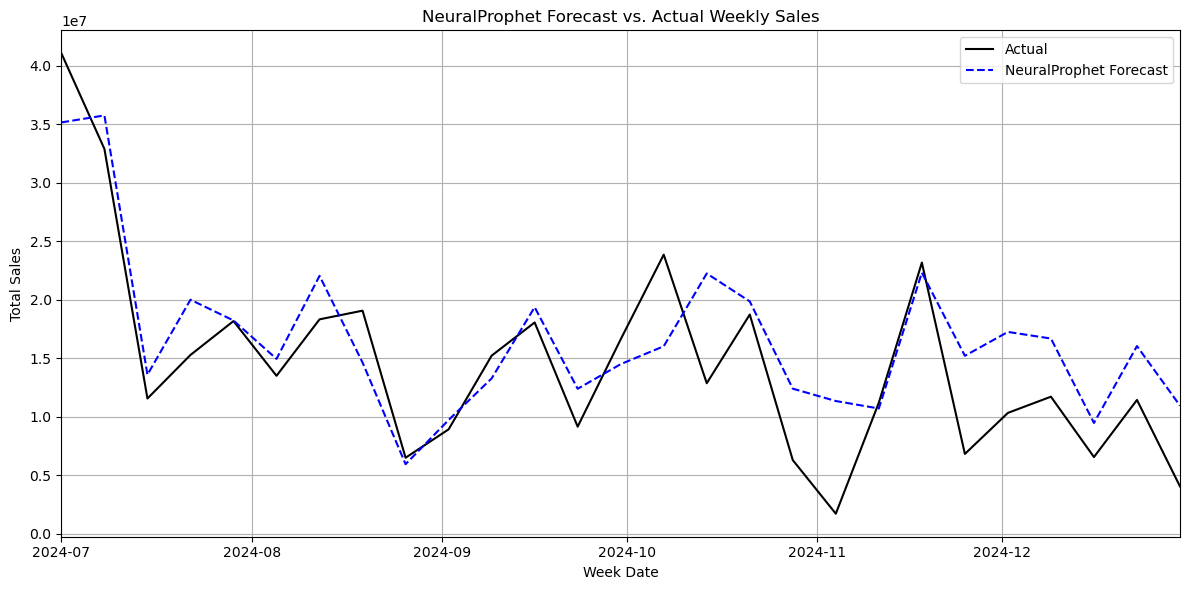

[I 2025-06-18 13:59:27,795] A new study created in memory with name: Prophet_tuning



Optimizing Prophet...


13:59:28 - cmdstanpy - INFO - Chain [1] start processing
13:59:28 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-06-18 13:59:28,742] Trial 0 finished with value: 45517571997294.69 and parameters: {'changepoint_prior_scale': 0.05611516415334506, 'n_changepoints': 20, 'seasonality_prior_scale': 14.666679442046961, 'seasonality_mode': 'additive'}. Best is trial 0 with value: 45517571997294.69.
13:59:28 - cmdstanpy - INFO - Chain [1] start processing
13:59:28 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-06-18 13:59:28,843] Trial 1 finished with value: 46260307764876.516 and parameters: {'changepoint_prior_scale': 0.020511104188433976, 'n_changepoints': 5, 'seasonality_prior_scale': 17.33690530092121, 'seasonality_mode': 'multiplicative'}. Best is trial 0 with value: 45517571997294.69.
13:59:28 - cmdstanpy - INFO - Chain [1] start processing
13:59:28 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-06-18 13:59:28,932] Trial 2 finished with value: 52900948711617.12 an


Best Parameters for Prophet:
{'changepoint_prior_scale': 0.9658704587603621, 'n_changepoints': 16, 'seasonality_prior_scale': 7.24447121385322, 'seasonality_mode': 'multiplicative'}
Best trial was at: 41

Evaluation Metrics for Prophet:
RMSE: 5443770.96
MAE: 4627710.59
MAPE: 40.71%


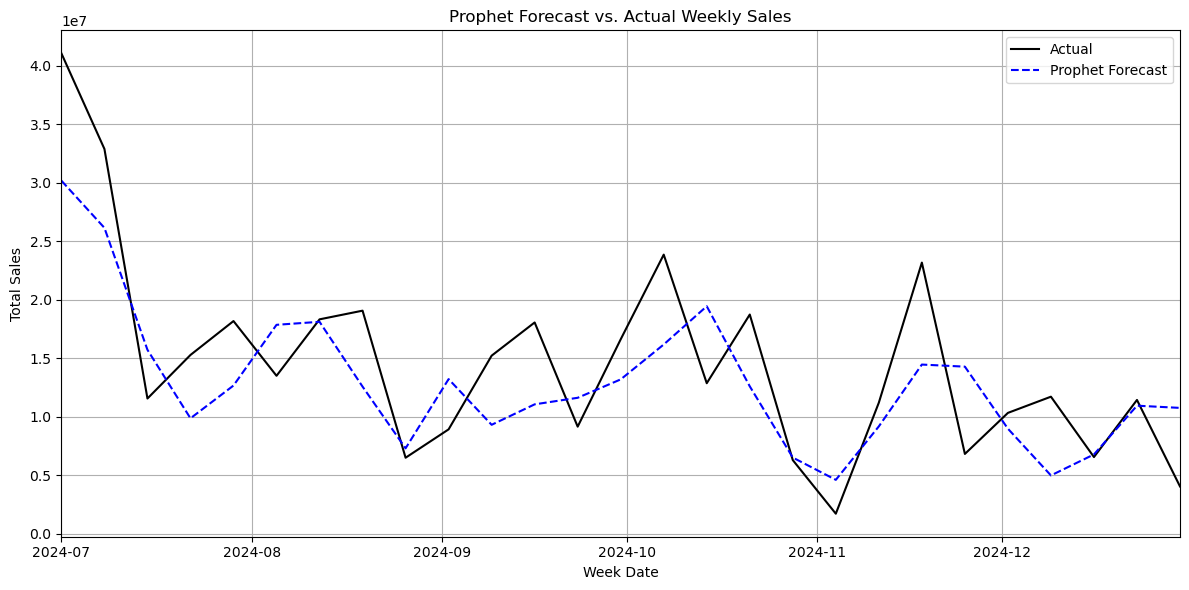

[I 2025-06-18 13:59:34,098] A new study created in memory with name: ETSX_tuning



Optimizing ETSX...
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           57     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  5.68378D+00    |proj g|=  9.88789D-01

At iterate    1    f=  5.01253D+00    |proj g|=  1.18418D-01

At iterate    2    f=  4.92635D+00    |proj g|=  9.99800D-01

At iterate    3    f=  4.75798D+00    |proj g|=  2.05889D-01

At iterate    4    f=  4.74732D+00    |proj g|=  2.93076D-01

At iterate    5    f=  4.74166D+00    |proj g|=  1.80000D-01

At iterate    6    f=  4.71143D+00    |proj g|=  1.49752D-01

At iterate    7    f=  4.67821D+00    |proj g|=  5.77055D-02

At iterate    8    f=  4.66092D+00    |proj g|=  6.21929D-02

At iterate    9    f=  4.65541D+00    |proj g|=  5.58220D-02

At iterate   10    f=  4.64846D+00    |proj g|=  3.34403D-02

At iterate   11    f=  4.64494D+00    |proj g|=  1.13307D-02

At iterate   12    f=  4.64464D+00    |proj g|=  8.47047D-03

At ite

[I 2025-06-18 13:59:34,608] Trial 0 finished with value: inf and parameters: {'error': 'mul', 'trend': 'add', 'damped_trend': True, 'seasonal': 'mul'}. Best is trial 0 with value: inf.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           57     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  5.68351D+00    |proj g|=  9.88789D-01

At iterate    1    f=  5.39937D+00    |proj g|=  2.44682D+00

At iterate    2    f=  5.10242D+00    |proj g|=  3.37313D+00

At iterate    3    f=  5.02894D+00    |proj g|=  1.89484D+00

At iterate    4    f=  5.00429D+00    |proj g|=  6.56961D-01

At iterate    5    f=  4.96721D+00    |proj g|=  2.64912D+00

At iterate    6    f=  4.92159D+00    |proj g|=  2.54606D+00

At iterate    7    f=  4.86710D+00    |proj g|=  2.23240D+00

At iterate    8    f=  4.83941D+00    |proj g|=  3.05422D+00

At iterate    9    f=  4.81486D+00    |proj g|=  1.43374D-01

At iterate   10    f=  4.80999D+00    |proj g|=  2.38783D-01

At iterate   11    f=  4.79417D+00    |proj g|=  3.44446D-01

At iterate   12    f=  4.78577D+00    |proj g|=  8.57566D-02

At iterate   13    f=  4.7

[I 2025-06-18 13:59:35,435] Trial 1 finished with value: inf and parameters: {'error': 'mul', 'trend': 'mul', 'damped_trend': True, 'seasonal': 'mul'}. Best is trial 0 with value: inf.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           57     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  5.68378D+00    |proj g|=  9.88789D-01

At iterate    1    f=  5.01253D+00    |proj g|=  1.18418D-01

At iterate    2    f=  4.92635D+00    |proj g|=  9.99800D-01

At iterate    3    f=  4.75798D+00    |proj g|=  2.05889D-01

At iterate    4    f=  4.74732D+00    |proj g|=  2.93076D-01

At iterate    5    f=  4.74166D+00    |proj g|=  1.80000D-01

At iterate    6    f=  4.71143D+00    |proj g|=  1.49752D-01

At iterate    7    f=  4.67821D+00    |proj g|=  5.77055D-02

At iterate    8    f=  4.66092D+00    |proj g|=  6.21929D-02

At iterate    9    f=  4.65541D+00    |proj g|=  5.58220D-02

At iterate   10    f=  4.64846D+00    |proj g|=  3.34403D-02

At iterate   11    f=  4.64494D+00    |proj g|=  1.13307D-02

At iterate   12    f=  4.64464D+00    |proj g|=  8.47047D-03

At iterate   13    f=  4.6

[I 2025-06-18 13:59:36,004] Trial 2 finished with value: inf and parameters: {'error': 'mul', 'trend': 'add', 'damped_trend': True, 'seasonal': 'mul'}. Best is trial 0 with value: inf.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           57     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  5.69785D+00    |proj g|=  9.88789D-01

At iterate    1    f=  5.59925D+00    |proj g|=  1.43353D+00

At iterate    2    f=  5.48171D+00    |proj g|=  1.33292D+00

At iterate    3    f=  5.27688D+00    |proj g|=  2.12304D+00

At iterate    4    f=  5.21127D+00    |proj g|=  1.25282D+00

At iterate    5    f=  5.16877D+00    |proj g|=  4.12043D-01

At iterate    6    f=  5.15326D+00    |proj g|=  1.56725D+00

At iterate    7    f=  5.14729D+00    |proj g|=  6.64528D-01

At iterate    8    f=  5.14560D+00    |proj g|=  1.61045D-01

At iterate    9    f=  5.14546D+00    |proj g|=  1.23783D-01

At iterate   10    f=  5.14542D+00    |proj g|=  2.93738D-02

At iterate   11    f=  5.14541D+00    |proj g|=  2.19273D-03

At iterate   12    f=  5.14541D+00    |proj g|=  2.07203D-03

At iterate   13    f=  5.1

[I 2025-06-18 13:59:36,544] Trial 3 finished with value: inf and parameters: {'error': 'mul', 'trend': 'mul', 'damped_trend': True, 'seasonal': 'add'}. Best is trial 0 with value: inf.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           57     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  5.70242D+00    |proj g|=  9.88789D-01

At iterate    1    f=  5.15531D+00    |proj g|=  3.08508D-02

At iterate    2    f=  5.15450D+00    |proj g|=  1.69047D-02

At iterate    3    f=  5.15409D+00    |proj g|=  1.64316D-02

At iterate    4    f=  5.15403D+00    |proj g|=  1.63797D-02

At iterate    5    f=  5.15342D+00    |proj g|=  3.36084D-02

At iterate    6    f=  5.15300D+00    |proj g|=  3.36057D-02

At iterate    7    f=  5.15195D+00    |proj g|=  6.84334D-02

At iterate    8    f=  5.15100D+00    |proj g|=  1.23155D-02

At iterate    9    f=  5.14935D+00    |proj g|=  1.31858D-02

At iterate   10    f=  5.14774D+00    |proj g|=  2.42378D-02

At iterate   11    f=  5.14671D+00    |proj g|=  2.48610D-02

At iterate   12    f=  5.14595D+00    |proj g|=  2.14881D-02

At iterate   13    f=  5.1

[I 2025-06-18 13:59:37,425] Trial 4 finished with value: inf and parameters: {'error': 'mul', 'trend': 'add', 'damped_trend': True, 'seasonal': 'add'}. Best is trial 0 with value: inf.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           56     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.68398D+00    |proj g|=  9.88789D-01

At iterate    1    f=  5.57979D+00    |proj g|=  9.18268D-01

At iterate    2    f=  5.39249D+00    |proj g|=  7.35407D-01

At iterate    3    f=  5.28581D+00    |proj g|=  1.95608D+00

At iterate    4    f=  5.17295D+00    |proj g|=  4.92153D+00

At iterate    5    f=  5.00420D+00    |proj g|=  6.32814D+00

At iterate    6    f=  4.98528D+00    |proj g|=  3.59138D+00

At iterate    7    f=  4.94464D+00    |proj g|=  2.17062D+00

At iterate    8    f=  4.88099D+00    |proj g|=  7.05541D+01

At iterate    9    f=  4.84961D+00    |proj g|=  4.94175D+00

At iterate   10    f=  4.81734D+00    |proj g|=  8.03427D+00

At iterate   11    f=  4.76461D+00    |proj g|=  1.51848D+00

At iterate   12    f=  4.76286D+00    |proj g|=  1.12149D+00

At iterate   13    f=  4.7

[I 2025-06-18 13:59:38,208] Trial 5 finished with value: inf and parameters: {'error': 'mul', 'trend': 'mul', 'damped_trend': False, 'seasonal': 'mul'}. Best is trial 0 with value: inf.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           57     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  5.66260D+00    |proj g|=  9.88789D-01

At iterate    1    f=  5.00160D+00    |proj g|=  5.90843D-01

At iterate    2    f=  4.98452D+00    |proj g|=  1.15392D-01

At iterate    3    f=  4.92487D+00    |proj g|=  1.15289D-01

At iterate    4    f=  4.58924D+00    |proj g|=  9.28375D-02

At iterate    5    f=  4.53941D+00    |proj g|=  6.66723D-02

At iterate    6    f=  4.52121D+00    |proj g|=  9.99800D-01

At iterate    7    f=  4.51918D+00    |proj g|=  4.15884D-02

At iterate    8    f=  4.51681D+00    |proj g|=  2.58623D-02

At iterate    9    f=  4.50803D+00    |proj g|=  4.51930D-02

At iterate   10    f=  4.50424D+00    |proj g|=  4.55769D-02

At iterate   11    f=  4.50185D+00    |proj g|=  1.38460D-02

At iterate   12    f=  4.50168D+00    |proj g|=  9.35811D-03

At iterate   13    f=  4.5

[I 2025-06-18 13:59:38,828] Trial 6 finished with value: inf and parameters: {'error': 'add', 'trend': 'add', 'damped_trend': True, 'seasonal': 'mul'}. Best is trial 0 with value: inf.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           57     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  5.69785D+00    |proj g|=  9.88789D-01

At iterate    1    f=  5.59925D+00    |proj g|=  1.43353D+00

At iterate    2    f=  5.48171D+00    |proj g|=  1.33292D+00

At iterate    3    f=  5.27688D+00    |proj g|=  2.12304D+00

At iterate    4    f=  5.21127D+00    |proj g|=  1.25282D+00

At iterate    5    f=  5.16877D+00    |proj g|=  4.12043D-01

At iterate    6    f=  5.15326D+00    |proj g|=  1.56725D+00

At iterate    7    f=  5.14729D+00    |proj g|=  6.64528D-01

At iterate    8    f=  5.14560D+00    |proj g|=  1.61045D-01

At iterate    9    f=  5.14546D+00    |proj g|=  1.23783D-01

At iterate   10    f=  5.14542D+00    |proj g|=  2.93738D-02

At iterate   11    f=  5.14541D+00    |proj g|=  2.19273D-03

At iterate   12    f=  5.14541D+00    |proj g|=  2.07203D-03

At iterate   13    f=  5.1

[I 2025-06-18 13:59:39,392] Trial 7 finished with value: inf and parameters: {'error': 'mul', 'trend': 'mul', 'damped_trend': True, 'seasonal': 'add'}. Best is trial 0 with value: inf.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           56     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.69855D+00    |proj g|=  9.88789D-01

At iterate    1    f=  5.68241D+00    |proj g|=  9.79429D-01

At iterate    2    f=  5.59145D+00    |proj g|=  1.86355D+00

At iterate    3    f=  5.50445D+00    |proj g|=  4.06041D+00

At iterate    4    f=  5.28610D+00    |proj g|=  5.11436D-01

At iterate    5    f=  5.25223D+00    |proj g|=  5.27087D+00

At iterate    6    f=  5.20635D+00    |proj g|=  4.31820D-01

At iterate    7    f=  5.17751D+00    |proj g|=  2.16590D+00

At iterate    8    f=  5.17201D+00    |proj g|=  7.19370D+00

At iterate    9    f=  5.17192D+00    |proj g|=  8.20521D+00

At iterate   10    f=  5.17148D+00    |proj g|=  1.05510D+01

At iterate   11    f=  5.16818D+00    |proj g|=  1.82133D+01

At iterate   12    f=  5.15712D+00    |proj g|=  1.50692D+01

At iterate   13    f=  5.1

[I 2025-06-18 13:59:39,828] Trial 8 finished with value: inf and parameters: {'error': 'mul', 'trend': 'mul', 'damped_trend': False, 'seasonal': 'add'}. Best is trial 0 with value: inf.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           57     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  5.69785D+00    |proj g|=  9.88789D-01

At iterate    1    f=  5.59925D+00    |proj g|=  1.43353D+00

At iterate    2    f=  5.48171D+00    |proj g|=  1.33292D+00

At iterate    3    f=  5.27688D+00    |proj g|=  2.12304D+00

At iterate    4    f=  5.21127D+00    |proj g|=  1.25282D+00

At iterate    5    f=  5.16877D+00    |proj g|=  4.12043D-01

At iterate    6    f=  5.15326D+00    |proj g|=  1.56725D+00

At iterate    7    f=  5.14729D+00    |proj g|=  6.64528D-01

At iterate    8    f=  5.14560D+00    |proj g|=  1.61045D-01

At iterate    9    f=  5.14546D+00    |proj g|=  1.23783D-01

At iterate   10    f=  5.14542D+00    |proj g|=  2.93738D-02

At iterate   11    f=  5.14541D+00    |proj g|=  2.19273D-03

At iterate   12    f=  5.14541D+00    |proj g|=  2.07203D-03

At iterate   13    f=  5.1

[I 2025-06-18 13:59:40,379] Trial 9 finished with value: inf and parameters: {'error': 'mul', 'trend': 'mul', 'damped_trend': True, 'seasonal': 'add'}. Best is trial 0 with value: inf.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           56     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.66274D+00    |proj g|=  9.88789D-01

At iterate    1    f=  5.00060D+00    |proj g|=  6.80007D-01

At iterate    2    f=  4.98628D+00    |proj g|=  1.14339D-01

At iterate    3    f=  4.93598D+00    |proj g|=  1.13458D-01

At iterate    4    f=  4.63090D+00    |proj g|=  1.09307D-01

At iterate    5    f=  4.56446D+00    |proj g|=  6.76439D-02

At iterate    6    f=  4.53098D+00    |proj g|=  9.99800D-01

At iterate    7    f=  4.52535D+00    |proj g|=  5.64933D-02

At iterate    8    f=  4.51264D+00    |proj g|=  3.34117D-02

At iterate    9    f=  4.50767D+00    |proj g|=  1.38789D-01

At iterate   10    f=  4.50474D+00    |proj g|=  3.59405D-01

At iterate   11    f=  4.50202D+00    |proj g|=  4.77718D-02

At iterate   12    f=  4.50095D+00    |proj g|=  6.35832D-02

At iterate   13    f=  4.5

[I 2025-06-18 13:59:40,776] Trial 10 finished with value: inf and parameters: {'error': 'add', 'trend': 'add', 'damped_trend': False, 'seasonal': 'mul'}. Best is trial 0 with value: inf.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           57     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  5.66260D+00    |proj g|=  9.88789D-01

At iterate    1    f=  5.00160D+00    |proj g|=  5.90843D-01

At iterate    2    f=  4.98452D+00    |proj g|=  1.15392D-01

At iterate    3    f=  4.92487D+00    |proj g|=  1.15289D-01

At iterate    4    f=  4.58924D+00    |proj g|=  9.28375D-02

At iterate    5    f=  4.53941D+00    |proj g|=  6.66723D-02

At iterate    6    f=  4.52121D+00    |proj g|=  9.99800D-01

At iterate    7    f=  4.51918D+00    |proj g|=  4.15884D-02

At iterate    8    f=  4.51681D+00    |proj g|=  2.58623D-02

At iterate    9    f=  4.50803D+00    |proj g|=  4.51930D-02

At iterate   10    f=  4.50424D+00    |proj g|=  4.55769D-02

At iterate   11    f=  4.50185D+00    |proj g|=  1.38460D-02

At iterate   12    f=  4.50168D+00    |proj g|=  9.35811D-03

At iterate   13    f=  4.5

[I 2025-06-18 13:59:41,255] Trial 11 finished with value: inf and parameters: {'error': 'add', 'trend': 'add', 'damped_trend': True, 'seasonal': 'mul'}. Best is trial 0 with value: inf.



At iterate   48    f=  4.50038D+00    |proj g|=  6.53442D-03

At iterate   49    f=  4.50019D+00    |proj g|=  4.73976D-03

At iterate   50    f=  4.50007D+00    |proj g|=  1.06484D-03

At iterate   51    f=  4.50006D+00    |proj g|=  4.20020D-04

At iterate   52    f=  4.50006D+00    |proj g|=  2.81553D-04

At iterate   53    f=  4.50006D+00    |proj g|=  9.21041D-05

At iterate   54    f=  4.50006D+00    |proj g|=  3.53495D-05

At iterate   55    f=  4.50006D+00    |proj g|=  1.20792D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   57     55     62     62     0     4   1.208D-05   4.500D+00
  F =   4.50006384311

[I 2025-06-18 13:59:41,768] Trial 12 finished with value: inf and parameters: {'error': 'mul', 'trend': 'add', 'damped_trend': True, 'seasonal': 'mul'}. Best is trial 0 with value: inf.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           57     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  5.68351D+00    |proj g|=  9.88789D-01

At iterate    1    f=  5.39937D+00    |proj g|=  2.44682D+00

At iterate    2    f=  5.10242D+00    |proj g|=  3.37313D+00

At iterate    3    f=  5.02894D+00    |proj g|=  1.89484D+00

At iterate    4    f=  5.00429D+00    |proj g|=  6.56961D-01

At iterate    5    f=  4.96721D+00    |proj g|=  2.64912D+00

At iterate    6    f=  4.92159D+00    |proj g|=  2.54606D+00

At iterate    7    f=  4.86710D+00    |proj g|=  2.23240D+00

At iterate    8    f=  4.83941D+00    |proj g|=  3.05422D+00

At iterate    9    f=  4.81486D+00    |proj g|=  1.43374D-01

At iterate   10    f=  4.80999D+00    |proj g|=  2.38783D-01

At iterate   11    f=  4.79417D+00    |proj g|=  3.44446D-01

At iterate   12    f=  4.78577D+00    |proj g|=  8.57566D-02

At iterate   13    f=  4.7

[I 2025-06-18 13:59:42,580] Trial 13 finished with value: inf and parameters: {'error': 'mul', 'trend': 'mul', 'damped_trend': True, 'seasonal': 'mul'}. Best is trial 0 with value: inf.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           56     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.66731D+00    |proj g|=  9.88789D-01

At iterate    1    f=  5.56307D+00    |proj g|=  2.17686D+00

At iterate    2    f=  5.44835D+00    |proj g|=  1.23815D+00

At iterate    3    f=  5.33428D+00    |proj g|=  8.52328D-01

At iterate    4    f=  5.18605D+00    |proj g|=  1.69361D+00

At iterate    5    f=  5.10036D+00    |proj g|=  3.17697D-01

At iterate    6    f=  5.05704D+00    |proj g|=  2.85711D-01

At iterate    7    f=  4.89251D+00    |proj g|=  6.84069D-01

At iterate    8    f=  4.85009D+00    |proj g|=  8.21867D-01

At iterate    9    f=  4.77783D+00    |proj g|=  3.58676D+00

At iterate   10    f=  4.74768D+00    |proj g|=  1.04502D+00

At iterate   11    f=  4.74512D+00    |proj g|=  7.59467D-01

At iterate   12    f=  4.73865D+00    |proj g|=  3.82767D-01

At iterate   13    f=  4.7

[I 2025-06-18 13:59:43,152] Trial 14 finished with value: inf and parameters: {'error': 'add', 'trend': 'mul', 'damped_trend': False, 'seasonal': 'mul'}. Best is trial 0 with value: inf.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           57     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  5.68378D+00    |proj g|=  9.88789D-01

At iterate    1    f=  5.01253D+00    |proj g|=  1.18418D-01

At iterate    2    f=  4.92635D+00    |proj g|=  9.99800D-01

At iterate    3    f=  4.75798D+00    |proj g|=  2.05889D-01

At iterate    4    f=  4.74732D+00    |proj g|=  2.93076D-01

At iterate    5    f=  4.74166D+00    |proj g|=  1.80000D-01

At iterate    6    f=  4.71143D+00    |proj g|=  1.49752D-01

At iterate    7    f=  4.67821D+00    |proj g|=  5.77055D-02

At iterate    8    f=  4.66092D+00    |proj g|=  6.21929D-02

At iterate    9    f=  4.65541D+00    |proj g|=  5.58220D-02

At iterate   10    f=  4.64846D+00    |proj g|=  3.34403D-02

At iterate   11    f=  4.64494D+00    |proj g|=  1.13307D-02

At iterate   12    f=  4.64464D+00    |proj g|=  8.47047D-03

At iterate   13    f=  4.6

[I 2025-06-18 13:59:43,675] Trial 15 finished with value: inf and parameters: {'error': 'mul', 'trend': 'add', 'damped_trend': True, 'seasonal': 'mul'}. Best is trial 0 with value: inf.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           57     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  5.68378D+00    |proj g|=  9.88789D-01

At iterate    1    f=  5.01253D+00    |proj g|=  1.18418D-01

At iterate    2    f=  4.92635D+00    |proj g|=  9.99800D-01

At iterate    3    f=  4.75798D+00    |proj g|=  2.05889D-01

At iterate    4    f=  4.74732D+00    |proj g|=  2.93076D-01

At iterate    5    f=  4.74166D+00    |proj g|=  1.80000D-01

At iterate    6    f=  4.71143D+00    |proj g|=  1.49752D-01

At iterate    7    f=  4.67821D+00    |proj g|=  5.77055D-02

At iterate    8    f=  4.66092D+00    |proj g|=  6.21929D-02

At iterate    9    f=  4.65541D+00    |proj g|=  5.58220D-02

At iterate   10    f=  4.64846D+00    |proj g|=  3.34403D-02

At iterate   11    f=  4.64494D+00    |proj g|=  1.13307D-02

At iterate   12    f=  4.64464D+00    |proj g|=  8.47047D-03

At iterate   13    f=  4.6

[I 2025-06-18 13:59:44,245] Trial 16 finished with value: inf and parameters: {'error': 'mul', 'trend': 'add', 'damped_trend': True, 'seasonal': 'mul'}. Best is trial 0 with value: inf.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           57     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  5.68351D+00    |proj g|=  9.88789D-01

At iterate    1    f=  5.39937D+00    |proj g|=  2.44682D+00

At iterate    2    f=  5.10242D+00    |proj g|=  3.37313D+00

At iterate    3    f=  5.02894D+00    |proj g|=  1.89484D+00

At iterate    4    f=  5.00429D+00    |proj g|=  6.56961D-01

At iterate    5    f=  4.96721D+00    |proj g|=  2.64912D+00

At iterate    6    f=  4.92159D+00    |proj g|=  2.54606D+00

At iterate    7    f=  4.86710D+00    |proj g|=  2.23240D+00

At iterate    8    f=  4.83941D+00    |proj g|=  3.05422D+00

At iterate    9    f=  4.81486D+00    |proj g|=  1.43374D-01

At iterate   10    f=  4.80999D+00    |proj g|=  2.38783D-01

At iterate   11    f=  4.79417D+00    |proj g|=  3.44446D-01

At iterate   12    f=  4.78577D+00    |proj g|=  8.57566D-02

At iterate   13    f=  4.7

[I 2025-06-18 13:59:45,047] Trial 17 finished with value: inf and parameters: {'error': 'mul', 'trend': 'mul', 'damped_trend': True, 'seasonal': 'mul'}. Best is trial 0 with value: inf.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           56     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.66274D+00    |proj g|=  9.88789D-01

At iterate    1    f=  5.00060D+00    |proj g|=  6.80007D-01

At iterate    2    f=  4.98628D+00    |proj g|=  1.14339D-01

At iterate    3    f=  4.93598D+00    |proj g|=  1.13458D-01

At iterate    4    f=  4.63090D+00    |proj g|=  1.09307D-01

At iterate    5    f=  4.56446D+00    |proj g|=  6.76439D-02

At iterate    6    f=  4.53098D+00    |proj g|=  9.99800D-01

At iterate    7    f=  4.52535D+00    |proj g|=  5.64933D-02

At iterate    8    f=  4.51264D+00    |proj g|=  3.34117D-02

At iterate    9    f=  4.50767D+00    |proj g|=  1.38789D-01

At iterate   10    f=  4.50474D+00    |proj g|=  3.59405D-01

At iterate   11    f=  4.50202D+00    |proj g|=  4.77718D-02

At iterate   12    f=  4.50095D+00    |proj g|=  6.35832D-02

At iterate   13    f=  4.5

[I 2025-06-18 13:59:45,432] Trial 18 finished with value: inf and parameters: {'error': 'add', 'trend': 'add', 'damped_trend': False, 'seasonal': 'mul'}. Best is trial 0 with value: inf.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           57     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  5.68351D+00    |proj g|=  9.88789D-01

At iterate    1    f=  5.39937D+00    |proj g|=  2.44682D+00

At iterate    2    f=  5.10242D+00    |proj g|=  3.37313D+00

At iterate    3    f=  5.02894D+00    |proj g|=  1.89484D+00

At iterate    4    f=  5.00429D+00    |proj g|=  6.56961D-01

At iterate    5    f=  4.96721D+00    |proj g|=  2.64912D+00

At iterate    6    f=  4.92159D+00    |proj g|=  2.54606D+00

At iterate    7    f=  4.86710D+00    |proj g|=  2.23240D+00

At iterate    8    f=  4.83941D+00    |proj g|=  3.05422D+00

At iterate    9    f=  4.81486D+00    |proj g|=  1.43374D-01

At iterate   10    f=  4.80999D+00    |proj g|=  2.38783D-01

At iterate   11    f=  4.79417D+00    |proj g|=  3.44446D-01

At iterate   12    f=  4.78577D+00    |proj g|=  8.57566D-02

At iterate   13    f=  4.7

[I 2025-06-18 13:59:46,254] Trial 19 finished with value: inf and parameters: {'error': 'mul', 'trend': 'mul', 'damped_trend': True, 'seasonal': 'mul'}. Best is trial 0 with value: inf.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           57     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  5.68351D+00    |proj g|=  9.88789D-01

At iterate    1    f=  5.39937D+00    |proj g|=  2.44682D+00

At iterate    2    f=  5.10242D+00    |proj g|=  3.37313D+00

At iterate    3    f=  5.02894D+00    |proj g|=  1.89484D+00

At iterate    4    f=  5.00429D+00    |proj g|=  6.56961D-01

At iterate    5    f=  4.96721D+00    |proj g|=  2.64912D+00

At iterate    6    f=  4.92159D+00    |proj g|=  2.54606D+00

At iterate    7    f=  4.86710D+00    |proj g|=  2.23240D+00

At iterate    8    f=  4.83941D+00    |proj g|=  3.05422D+00

At iterate    9    f=  4.81486D+00    |proj g|=  1.43374D-01

At iterate   10    f=  4.80999D+00    |proj g|=  2.38783D-01

At iterate   11    f=  4.79417D+00    |proj g|=  3.44446D-01

At iterate   12    f=  4.78577D+00    |proj g|=  8.57566D-02

At iterate   13    f=  4.7

[I 2025-06-18 13:59:47,071] Trial 20 finished with value: inf and parameters: {'error': 'mul', 'trend': 'mul', 'damped_trend': True, 'seasonal': 'mul'}. Best is trial 0 with value: inf.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           57     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  5.68378D+00    |proj g|=  9.88789D-01

At iterate    1    f=  5.01253D+00    |proj g|=  1.18418D-01

At iterate    2    f=  4.92635D+00    |proj g|=  9.99800D-01

At iterate    3    f=  4.75798D+00    |proj g|=  2.05889D-01

At iterate    4    f=  4.74732D+00    |proj g|=  2.93076D-01

At iterate    5    f=  4.74166D+00    |proj g|=  1.80000D-01

At iterate    6    f=  4.71143D+00    |proj g|=  1.49752D-01

At iterate    7    f=  4.67821D+00    |proj g|=  5.77055D-02

At iterate    8    f=  4.66092D+00    |proj g|=  6.21929D-02

At iterate    9    f=  4.65541D+00    |proj g|=  5.58220D-02

At iterate   10    f=  4.64846D+00    |proj g|=  3.34403D-02

At iterate   11    f=  4.64494D+00    |proj g|=  1.13307D-02

At iterate   12    f=  4.64464D+00    |proj g|=  8.47047D-03

At iterate   13    f=  4.6

[I 2025-06-18 13:59:47,621] Trial 21 finished with value: inf and parameters: {'error': 'mul', 'trend': 'add', 'damped_trend': True, 'seasonal': 'mul'}. Best is trial 0 with value: inf.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           57     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  5.68378D+00    |proj g|=  9.88789D-01

At iterate    1    f=  5.01253D+00    |proj g|=  1.18418D-01

At iterate    2    f=  4.92635D+00    |proj g|=  9.99800D-01

At iterate    3    f=  4.75798D+00    |proj g|=  2.05889D-01

At iterate    4    f=  4.74732D+00    |proj g|=  2.93076D-01

At iterate    5    f=  4.74166D+00    |proj g|=  1.80000D-01

At iterate    6    f=  4.71143D+00    |proj g|=  1.49752D-01

At iterate    7    f=  4.67821D+00    |proj g|=  5.77055D-02

At iterate    8    f=  4.66092D+00    |proj g|=  6.21929D-02

At iterate    9    f=  4.65541D+00    |proj g|=  5.58220D-02

At iterate   10    f=  4.64846D+00    |proj g|=  3.34403D-02

At iterate   11    f=  4.64494D+00    |proj g|=  1.13307D-02

At iterate   12    f=  4.64464D+00    |proj g|=  8.47047D-03

At iterate   13    f=  4.6

[I 2025-06-18 13:59:48,174] Trial 22 finished with value: inf and parameters: {'error': 'mul', 'trend': 'add', 'damped_trend': True, 'seasonal': 'mul'}. Best is trial 0 with value: inf.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           57     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  5.68378D+00    |proj g|=  9.88789D-01

At iterate    1    f=  5.01253D+00    |proj g|=  1.18418D-01

At iterate    2    f=  4.92635D+00    |proj g|=  9.99800D-01

At iterate    3    f=  4.75798D+00    |proj g|=  2.05889D-01

At iterate    4    f=  4.74732D+00    |proj g|=  2.93076D-01

At iterate    5    f=  4.74166D+00    |proj g|=  1.80000D-01

At iterate    6    f=  4.71143D+00    |proj g|=  1.49752D-01

At iterate    7    f=  4.67821D+00    |proj g|=  5.77055D-02

At iterate    8    f=  4.66092D+00    |proj g|=  6.21929D-02

At iterate    9    f=  4.65541D+00    |proj g|=  5.58220D-02

At iterate   10    f=  4.64846D+00    |proj g|=  3.34403D-02

At iterate   11    f=  4.64494D+00    |proj g|=  1.13307D-02

At iterate   12    f=  4.64464D+00    |proj g|=  8.47047D-03

At iterate   13    f=  4.6

[I 2025-06-18 13:59:48,722] Trial 23 finished with value: inf and parameters: {'error': 'mul', 'trend': 'add', 'damped_trend': True, 'seasonal': 'mul'}. Best is trial 0 with value: inf.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           57     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  5.68378D+00    |proj g|=  9.88789D-01

At iterate    1    f=  5.01253D+00    |proj g|=  1.18418D-01

At iterate    2    f=  4.92635D+00    |proj g|=  9.99800D-01

At iterate    3    f=  4.75798D+00    |proj g|=  2.05889D-01

At iterate    4    f=  4.74732D+00    |proj g|=  2.93076D-01

At iterate    5    f=  4.74166D+00    |proj g|=  1.80000D-01

At iterate    6    f=  4.71143D+00    |proj g|=  1.49752D-01

At iterate    7    f=  4.67821D+00    |proj g|=  5.77055D-02

At iterate    8    f=  4.66092D+00    |proj g|=  6.21929D-02

At iterate    9    f=  4.65541D+00    |proj g|=  5.58220D-02

At iterate   10    f=  4.64846D+00    |proj g|=  3.34403D-02

At iterate   11    f=  4.64494D+00    |proj g|=  1.13307D-02

At iterate   12    f=  4.64464D+00    |proj g|=  8.47047D-03

At iterate   13    f=  4.6

[I 2025-06-18 13:59:49,324] Trial 24 finished with value: inf and parameters: {'error': 'mul', 'trend': 'add', 'damped_trend': True, 'seasonal': 'mul'}. Best is trial 0 with value: inf.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           57     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  5.68378D+00    |proj g|=  9.88789D-01

At iterate    1    f=  5.01253D+00    |proj g|=  1.18418D-01

At iterate    2    f=  4.92635D+00    |proj g|=  9.99800D-01

At iterate    3    f=  4.75798D+00    |proj g|=  2.05889D-01

At iterate    4    f=  4.74732D+00    |proj g|=  2.93076D-01

At iterate    5    f=  4.74166D+00    |proj g|=  1.80000D-01

At iterate    6    f=  4.71143D+00    |proj g|=  1.49752D-01

At iterate    7    f=  4.67821D+00    |proj g|=  5.77055D-02

At iterate    8    f=  4.66092D+00    |proj g|=  6.21929D-02

At iterate    9    f=  4.65541D+00    |proj g|=  5.58220D-02

At iterate   10    f=  4.64846D+00    |proj g|=  3.34403D-02

At iterate   11    f=  4.64494D+00    |proj g|=  1.13307D-02

At iterate   12    f=  4.64464D+00    |proj g|=  8.47047D-03

At iterate   13    f=  4.6

[I 2025-06-18 13:59:49,988] Trial 25 finished with value: inf and parameters: {'error': 'mul', 'trend': 'add', 'damped_trend': True, 'seasonal': 'mul'}. Best is trial 0 with value: inf.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           56     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.64080D+00    |proj g|=  9.88789D-01

At iterate    1    f=  5.14514D+00    |proj g|=  9.99800D-01

At iterate    2    f=  5.14131D+00    |proj g|=  2.78059D-01

At iterate    3    f=  5.13924D+00    |proj g|=  5.93077D-02

At iterate    4    f=  5.13814D+00    |proj g|=  8.63942D-02

At iterate    5    f=  5.13760D+00    |proj g|=  9.20342D-02

At iterate    6    f=  5.13715D+00    |proj g|=  1.55956D-01

At iterate    7    f=  5.13662D+00    |proj g|=  4.89377D-02

At iterate    8    f=  5.13627D+00    |proj g|=  5.61588D-02

At iterate    9    f=  5.13553D+00    |proj g|=  2.36397D-01

At iterate   10    f=  5.13435D+00    |proj g|=  4.16206D-02

At iterate   11    f=  5.13361D+00    |proj g|=  3.73674D-03

At iterate   12    f=  5.13360D+00    |proj g|=  2.02815D-03

At iterate   13    f=  5.1

[I 2025-06-18 13:59:50,653] Trial 26 finished with value: inf and parameters: {'error': 'add', 'trend': 'add', 'damped_trend': False, 'seasonal': 'add'}. Best is trial 0 with value: inf.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           57     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  5.68378D+00    |proj g|=  9.88789D-01

At iterate    1    f=  5.01253D+00    |proj g|=  1.18418D-01

At iterate    2    f=  4.92635D+00    |proj g|=  9.99800D-01

At iterate    3    f=  4.75798D+00    |proj g|=  2.05889D-01

At iterate    4    f=  4.74732D+00    |proj g|=  2.93076D-01

At iterate    5    f=  4.74166D+00    |proj g|=  1.80000D-01

At iterate    6    f=  4.71143D+00    |proj g|=  1.49752D-01

At iterate    7    f=  4.67821D+00    |proj g|=  5.77055D-02

At iterate    8    f=  4.66092D+00    |proj g|=  6.21929D-02

At iterate    9    f=  4.65541D+00    |proj g|=  5.58220D-02

At iterate   10    f=  4.64846D+00    |proj g|=  3.34403D-02

At iterate   11    f=  4.64494D+00    |proj g|=  1.13307D-02

At iterate   12    f=  4.64464D+00    |proj g|=  8.47047D-03

At iterate   13    f=  4.6

[I 2025-06-18 13:59:51,265] Trial 27 finished with value: inf and parameters: {'error': 'mul', 'trend': 'add', 'damped_trend': True, 'seasonal': 'mul'}. Best is trial 0 with value: inf.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           57     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  5.68351D+00    |proj g|=  9.88789D-01

At iterate    1    f=  5.39937D+00    |proj g|=  2.44682D+00

At iterate    2    f=  5.10242D+00    |proj g|=  3.37313D+00

At iterate    3    f=  5.02894D+00    |proj g|=  1.89484D+00

At iterate    4    f=  5.00429D+00    |proj g|=  6.56961D-01

At iterate    5    f=  4.96721D+00    |proj g|=  2.64912D+00

At iterate    6    f=  4.92159D+00    |proj g|=  2.54606D+00

At iterate    7    f=  4.86710D+00    |proj g|=  2.23240D+00

At iterate    8    f=  4.83941D+00    |proj g|=  3.05422D+00

At iterate    9    f=  4.81486D+00    |proj g|=  1.43374D-01

At iterate   10    f=  4.80999D+00    |proj g|=  2.38783D-01

At iterate   11    f=  4.79417D+00    |proj g|=  3.44446D-01

At iterate   12    f=  4.78577D+00    |proj g|=  8.57566D-02

At iterate   13    f=  4.7

[I 2025-06-18 13:59:52,121] Trial 28 finished with value: inf and parameters: {'error': 'mul', 'trend': 'mul', 'damped_trend': True, 'seasonal': 'mul'}. Best is trial 0 with value: inf.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           57     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  5.69785D+00    |proj g|=  9.88789D-01

At iterate    1    f=  5.59925D+00    |proj g|=  1.43353D+00

At iterate    2    f=  5.48171D+00    |proj g|=  1.33292D+00

At iterate    3    f=  5.27688D+00    |proj g|=  2.12304D+00

At iterate    4    f=  5.21127D+00    |proj g|=  1.25282D+00

At iterate    5    f=  5.16877D+00    |proj g|=  4.12043D-01

At iterate    6    f=  5.15326D+00    |proj g|=  1.56725D+00

At iterate    7    f=  5.14729D+00    |proj g|=  6.64528D-01

At iterate    8    f=  5.14560D+00    |proj g|=  1.61045D-01

At iterate    9    f=  5.14546D+00    |proj g|=  1.23783D-01

At iterate   10    f=  5.14542D+00    |proj g|=  2.93738D-02

At iterate   11    f=  5.14541D+00    |proj g|=  2.19273D-03

At iterate   12    f=  5.14541D+00    |proj g|=  2.07203D-03

At iterate   13    f=  5.1

[I 2025-06-18 13:59:52,654] Trial 29 finished with value: inf and parameters: {'error': 'mul', 'trend': 'mul', 'damped_trend': True, 'seasonal': 'add'}. Best is trial 0 with value: inf.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           57     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  5.68378D+00    |proj g|=  9.88789D-01

At iterate    1    f=  5.01253D+00    |proj g|=  1.18418D-01

At iterate    2    f=  4.92635D+00    |proj g|=  9.99800D-01

At iterate    3    f=  4.75798D+00    |proj g|=  2.05889D-01

At iterate    4    f=  4.74732D+00    |proj g|=  2.93076D-01

At iterate    5    f=  4.74166D+00    |proj g|=  1.80000D-01

At iterate    6    f=  4.71143D+00    |proj g|=  1.49752D-01

At iterate    7    f=  4.67821D+00    |proj g|=  5.77055D-02

At iterate    8    f=  4.66092D+00    |proj g|=  6.21929D-02

At iterate    9    f=  4.65541D+00    |proj g|=  5.58220D-02

At iterate   10    f=  4.64846D+00    |proj g|=  3.34403D-02

At iterate   11    f=  4.64494D+00    |proj g|=  1.13307D-02

At iterate   12    f=  4.64464D+00    |proj g|=  8.47047D-03

At iterate   13    f=  4.6

[I 2025-06-18 13:59:53,208] Trial 30 finished with value: inf and parameters: {'error': 'mul', 'trend': 'add', 'damped_trend': True, 'seasonal': 'mul'}. Best is trial 0 with value: inf.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           57     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  5.69785D+00    |proj g|=  9.88789D-01

At iterate    1    f=  5.59925D+00    |proj g|=  1.43353D+00

At iterate    2    f=  5.48171D+00    |proj g|=  1.33292D+00

At iterate    3    f=  5.27688D+00    |proj g|=  2.12304D+00

At iterate    4    f=  5.21127D+00    |proj g|=  1.25282D+00

At iterate    5    f=  5.16877D+00    |proj g|=  4.12043D-01

At iterate    6    f=  5.15326D+00    |proj g|=  1.56725D+00

At iterate    7    f=  5.14729D+00    |proj g|=  6.64528D-01

At iterate    8    f=  5.14560D+00    |proj g|=  1.61045D-01

At iterate    9    f=  5.14546D+00    |proj g|=  1.23783D-01

At iterate   10    f=  5.14542D+00    |proj g|=  2.93738D-02

At iterate   11    f=  5.14541D+00    |proj g|=  2.19273D-03

At iterate   12    f=  5.14541D+00    |proj g|=  2.07203D-03

At iterate   13    f=  5.1

[I 2025-06-18 13:59:53,776] Trial 31 finished with value: inf and parameters: {'error': 'mul', 'trend': 'mul', 'damped_trend': True, 'seasonal': 'add'}. Best is trial 0 with value: inf.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           57     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  5.69785D+00    |proj g|=  9.88789D-01

At iterate    1    f=  5.59925D+00    |proj g|=  1.43353D+00

At iterate    2    f=  5.48171D+00    |proj g|=  1.33292D+00

At iterate    3    f=  5.27688D+00    |proj g|=  2.12304D+00

At iterate    4    f=  5.21127D+00    |proj g|=  1.25282D+00

At iterate    5    f=  5.16877D+00    |proj g|=  4.12043D-01

At iterate    6    f=  5.15326D+00    |proj g|=  1.56725D+00

At iterate    7    f=  5.14729D+00    |proj g|=  6.64528D-01

At iterate    8    f=  5.14560D+00    |proj g|=  1.61045D-01

At iterate    9    f=  5.14546D+00    |proj g|=  1.23783D-01

At iterate   10    f=  5.14542D+00    |proj g|=  2.93738D-02

At iterate   11    f=  5.14541D+00    |proj g|=  2.19273D-03

At iterate   12    f=  5.14541D+00    |proj g|=  2.07203D-03

At iterate   13    f=  5.1

[I 2025-06-18 13:59:54,308] Trial 32 finished with value: inf and parameters: {'error': 'mul', 'trend': 'mul', 'damped_trend': True, 'seasonal': 'add'}. Best is trial 0 with value: inf.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           57     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  5.69785D+00    |proj g|=  9.88789D-01

At iterate    1    f=  5.59925D+00    |proj g|=  1.43353D+00

At iterate    2    f=  5.48171D+00    |proj g|=  1.33292D+00

At iterate    3    f=  5.27688D+00    |proj g|=  2.12304D+00

At iterate    4    f=  5.21127D+00    |proj g|=  1.25282D+00

At iterate    5    f=  5.16877D+00    |proj g|=  4.12043D-01

At iterate    6    f=  5.15326D+00    |proj g|=  1.56725D+00

At iterate    7    f=  5.14729D+00    |proj g|=  6.64528D-01

At iterate    8    f=  5.14560D+00    |proj g|=  1.61045D-01

At iterate    9    f=  5.14546D+00    |proj g|=  1.23783D-01

At iterate   10    f=  5.14542D+00    |proj g|=  2.93738D-02

At iterate   11    f=  5.14541D+00    |proj g|=  2.19273D-03

At iterate   12    f=  5.14541D+00    |proj g|=  2.07203D-03

At iterate   13    f=  5.1

[I 2025-06-18 13:59:54,901] Trial 33 finished with value: inf and parameters: {'error': 'mul', 'trend': 'mul', 'damped_trend': True, 'seasonal': 'add'}. Best is trial 0 with value: inf.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           57     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  5.69785D+00    |proj g|=  9.88789D-01

At iterate    1    f=  5.59925D+00    |proj g|=  1.43353D+00

At iterate    2    f=  5.48171D+00    |proj g|=  1.33292D+00

At iterate    3    f=  5.27688D+00    |proj g|=  2.12304D+00

At iterate    4    f=  5.21127D+00    |proj g|=  1.25282D+00

At iterate    5    f=  5.16877D+00    |proj g|=  4.12043D-01

At iterate    6    f=  5.15326D+00    |proj g|=  1.56725D+00

At iterate    7    f=  5.14729D+00    |proj g|=  6.64528D-01

At iterate    8    f=  5.14560D+00    |proj g|=  1.61045D-01

At iterate    9    f=  5.14546D+00    |proj g|=  1.23783D-01

At iterate   10    f=  5.14542D+00    |proj g|=  2.93738D-02

At iterate   11    f=  5.14541D+00    |proj g|=  2.19273D-03

At iterate   12    f=  5.14541D+00    |proj g|=  2.07203D-03

At iterate   13    f=  5.1

[I 2025-06-18 13:59:55,451] Trial 34 finished with value: inf and parameters: {'error': 'mul', 'trend': 'mul', 'damped_trend': True, 'seasonal': 'add'}. Best is trial 0 with value: inf.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           56     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.69855D+00    |proj g|=  9.88789D-01

At iterate    1    f=  5.68241D+00    |proj g|=  9.79429D-01

At iterate    2    f=  5.59145D+00    |proj g|=  1.86355D+00

At iterate    3    f=  5.50445D+00    |proj g|=  4.06041D+00

At iterate    4    f=  5.28610D+00    |proj g|=  5.11436D-01

At iterate    5    f=  5.25223D+00    |proj g|=  5.27087D+00

At iterate    6    f=  5.20635D+00    |proj g|=  4.31820D-01

At iterate    7    f=  5.17751D+00    |proj g|=  2.16590D+00

At iterate    8    f=  5.17201D+00    |proj g|=  7.19370D+00

At iterate    9    f=  5.17192D+00    |proj g|=  8.20521D+00

At iterate   10    f=  5.17148D+00    |proj g|=  1.05510D+01

At iterate   11    f=  5.16818D+00    |proj g|=  1.82133D+01

At iterate   12    f=  5.15712D+00    |proj g|=  1.50692D+01

At iterate   13    f=  5.1

[I 2025-06-18 13:59:55,912] Trial 35 finished with value: inf and parameters: {'error': 'mul', 'trend': 'mul', 'damped_trend': False, 'seasonal': 'add'}. Best is trial 0 with value: inf.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           57     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  5.69785D+00    |proj g|=  9.88789D-01

At iterate    1    f=  5.59925D+00    |proj g|=  1.43353D+00

At iterate    2    f=  5.48171D+00    |proj g|=  1.33292D+00

At iterate    3    f=  5.27688D+00    |proj g|=  2.12304D+00

At iterate    4    f=  5.21127D+00    |proj g|=  1.25282D+00

At iterate    5    f=  5.16877D+00    |proj g|=  4.12043D-01

At iterate    6    f=  5.15326D+00    |proj g|=  1.56725D+00

At iterate    7    f=  5.14729D+00    |proj g|=  6.64528D-01

At iterate    8    f=  5.14560D+00    |proj g|=  1.61045D-01

At iterate    9    f=  5.14546D+00    |proj g|=  1.23783D-01

At iterate   10    f=  5.14542D+00    |proj g|=  2.93738D-02

At iterate   11    f=  5.14541D+00    |proj g|=  2.19273D-03

At iterate   12    f=  5.14541D+00    |proj g|=  2.07203D-03

At iterate   13    f=  5.1

[I 2025-06-18 13:59:56,474] Trial 36 finished with value: inf and parameters: {'error': 'mul', 'trend': 'mul', 'damped_trend': True, 'seasonal': 'add'}. Best is trial 0 with value: inf.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           57     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  5.64029D+00    |proj g|=  9.88789D-01

At iterate    1    f=  5.14133D+00    |proj g|=  6.18048D-01

At iterate    2    f=  5.13946D+00    |proj g|=  3.69567D-02

At iterate    3    f=  5.13845D+00    |proj g|=  3.29381D-02

At iterate    4    f=  5.13750D+00    |proj g|=  2.07652D-02

At iterate    5    f=  5.13637D+00    |proj g|=  1.76692D-02

At iterate    6    f=  5.13264D+00    |proj g|=  9.99800D-01

At iterate    7    f=  5.13216D+00    |proj g|=  4.18935D-02

At iterate    8    f=  5.13206D+00    |proj g|=  9.04208D-02

At iterate    9    f=  5.12998D+00    |proj g|=  5.26655D-02

At iterate   10    f=  5.12817D+00    |proj g|=  2.33104D-02

At iterate   11    f=  5.12698D+00    |proj g|=  9.65903D-03

At iterate   12    f=  5.12644D+00    |proj g|=  1.25119D-02

At iterate   13    f=  5.1

[I 2025-06-18 13:59:56,856] Trial 37 finished with value: inf and parameters: {'error': 'add', 'trend': 'add', 'damped_trend': True, 'seasonal': 'add'}. Best is trial 0 with value: inf.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           56     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.68398D+00    |proj g|=  9.88789D-01

At iterate    1    f=  5.57979D+00    |proj g|=  9.18268D-01

At iterate    2    f=  5.39249D+00    |proj g|=  7.35407D-01

At iterate    3    f=  5.28581D+00    |proj g|=  1.95608D+00

At iterate    4    f=  5.17295D+00    |proj g|=  4.92153D+00

At iterate    5    f=  5.00420D+00    |proj g|=  6.32814D+00

At iterate    6    f=  4.98528D+00    |proj g|=  3.59138D+00

At iterate    7    f=  4.94464D+00    |proj g|=  2.17062D+00

At iterate    8    f=  4.88099D+00    |proj g|=  7.05541D+01

At iterate    9    f=  4.84961D+00    |proj g|=  4.94175D+00

At iterate   10    f=  4.81734D+00    |proj g|=  8.03427D+00

At iterate   11    f=  4.76461D+00    |proj g|=  1.51848D+00

At iterate   12    f=  4.76286D+00    |proj g|=  1.12149D+00

At iterate   13    f=  4.7

[I 2025-06-18 13:59:57,650] Trial 38 finished with value: inf and parameters: {'error': 'mul', 'trend': 'mul', 'damped_trend': False, 'seasonal': 'mul'}. Best is trial 0 with value: inf.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           57     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  5.68378D+00    |proj g|=  9.88789D-01

At iterate    1    f=  5.01253D+00    |proj g|=  1.18418D-01

At iterate    2    f=  4.92635D+00    |proj g|=  9.99800D-01

At iterate    3    f=  4.75798D+00    |proj g|=  2.05889D-01

At iterate    4    f=  4.74732D+00    |proj g|=  2.93076D-01

At iterate    5    f=  4.74166D+00    |proj g|=  1.80000D-01

At iterate    6    f=  4.71143D+00    |proj g|=  1.49752D-01

At iterate    7    f=  4.67821D+00    |proj g|=  5.77055D-02

At iterate    8    f=  4.66092D+00    |proj g|=  6.21929D-02

At iterate    9    f=  4.65541D+00    |proj g|=  5.58220D-02

At iterate   10    f=  4.64846D+00    |proj g|=  3.34403D-02

At iterate   11    f=  4.64494D+00    |proj g|=  1.13307D-02

At iterate   12    f=  4.64464D+00    |proj g|=  8.47047D-03

At iterate   13    f=  4.6

[I 2025-06-18 13:59:58,261] Trial 39 finished with value: inf and parameters: {'error': 'mul', 'trend': 'add', 'damped_trend': True, 'seasonal': 'mul'}. Best is trial 0 with value: inf.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           57     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  5.64045D+00    |proj g|=  9.88789D-01

At iterate    1    f=  5.16057D+00    |proj g|=  1.29642D+01

At iterate    2    f=  5.12931D+00    |proj g|=  5.32389D-02

At iterate    3    f=  5.12913D+00    |proj g|=  1.56456D-01

At iterate    4    f=  5.12814D+00    |proj g|=  7.20241D-01

At iterate    5    f=  5.12792D+00    |proj g|=  3.18181D-01

At iterate    6    f=  5.12789D+00    |proj g|=  4.75890D-02

At iterate    7    f=  5.12788D+00    |proj g|=  6.21938D-02

At iterate    8    f=  5.12787D+00    |proj g|=  1.70933D-01

At iterate    9    f=  5.12785D+00    |proj g|=  3.15021D-01

At iterate   10    f=  5.12779D+00    |proj g|=  5.38434D-01

At iterate   11    f=  5.12764D+00    |proj g|=  7.97774D-01

At iterate   12    f=  5.12732D+00    |proj g|=  9.55353D-01

At iterate   13    f=  5.1

[I 2025-06-18 13:59:58,849] Trial 40 finished with value: inf and parameters: {'error': 'add', 'trend': 'mul', 'damped_trend': True, 'seasonal': 'add'}. Best is trial 0 with value: inf.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           57     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  5.70242D+00    |proj g|=  9.88789D-01

At iterate    1    f=  5.15531D+00    |proj g|=  3.08508D-02

At iterate    2    f=  5.15450D+00    |proj g|=  1.69047D-02

At iterate    3    f=  5.15409D+00    |proj g|=  1.64316D-02

At iterate    4    f=  5.15403D+00    |proj g|=  1.63797D-02

At iterate    5    f=  5.15342D+00    |proj g|=  3.36084D-02

At iterate    6    f=  5.15300D+00    |proj g|=  3.36057D-02

At iterate    7    f=  5.15195D+00    |proj g|=  6.84334D-02

At iterate    8    f=  5.15100D+00    |proj g|=  1.23155D-02

At iterate    9    f=  5.14935D+00    |proj g|=  1.31858D-02

At iterate   10    f=  5.14774D+00    |proj g|=  2.42378D-02

At iterate   11    f=  5.14671D+00    |proj g|=  2.48610D-02

At iterate   12    f=  5.14595D+00    |proj g|=  2.14881D-02

At iterate   13    f=  5.1

[I 2025-06-18 13:59:59,679] Trial 41 finished with value: inf and parameters: {'error': 'mul', 'trend': 'add', 'damped_trend': True, 'seasonal': 'add'}. Best is trial 0 with value: inf.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           57     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  5.70242D+00    |proj g|=  9.88789D-01

At iterate    1    f=  5.15531D+00    |proj g|=  3.08508D-02

At iterate    2    f=  5.15450D+00    |proj g|=  1.69047D-02

At iterate    3    f=  5.15409D+00    |proj g|=  1.64316D-02

At iterate    4    f=  5.15403D+00    |proj g|=  1.63797D-02

At iterate    5    f=  5.15342D+00    |proj g|=  3.36084D-02

At iterate    6    f=  5.15300D+00    |proj g|=  3.36057D-02

At iterate    7    f=  5.15195D+00    |proj g|=  6.84334D-02

At iterate    8    f=  5.15100D+00    |proj g|=  1.23155D-02

At iterate    9    f=  5.14935D+00    |proj g|=  1.31858D-02

At iterate   10    f=  5.14774D+00    |proj g|=  2.42378D-02

At iterate   11    f=  5.14671D+00    |proj g|=  2.48610D-02

At iterate   12    f=  5.14595D+00    |proj g|=  2.14881D-02

At iterate   13    f=  5.1

[I 2025-06-18 14:00:00,472] Trial 42 finished with value: inf and parameters: {'error': 'mul', 'trend': 'add', 'damped_trend': True, 'seasonal': 'add'}. Best is trial 0 with value: inf.



At iterate  111    f=  4.71001D+00    |proj g|=  6.93209D-02

At iterate  112    f=  4.70851D+00    |proj g|=  2.94063D-02

At iterate  113    f=  4.70691D+00    |proj g|=  4.74404D-02

At iterate  114    f=  4.70117D+00    |proj g|=  1.35523D-01

At iterate  115    f=  4.68742D+00    |proj g|=  5.83757D-02

At iterate  116    f=  4.68454D+00    |proj g|=  2.64213D-02

At iterate  117    f=  4.68238D+00    |proj g|=  9.48752D-04

At iterate  118    f=  4.68023D+00    |proj g|=  1.12518D-02

At iterate  119    f=  4.67725D+00    |proj g|=  1.20653D-02

At iterate  120    f=  4.67469D+00    |proj g|=  5.86748D-03

At iterate  121    f=  4.67286D+00    |proj g|=  1.67482D-02

At iterate  122    f=  4.66946D+00    |proj g|=  3.39402D-02

At iterate  123    f=  4.66520D+00    |proj g|=  4.82740D-02

At iterate  124    f=  4.66006D+00    |proj g|=  4.82125D-02

At iterate  125    f=  4.65509D+00    |proj g|=  7.45037D-02

At iterate  126    f=  4.65407D+00    |proj g|=  1.47034D-02

At iter

[I 2025-06-18 14:00:01,300] Trial 43 finished with value: inf and parameters: {'error': 'mul', 'trend': 'add', 'damped_trend': True, 'seasonal': 'add'}. Best is trial 0 with value: inf.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           57     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  5.70242D+00    |proj g|=  9.88789D-01

At iterate    1    f=  5.15531D+00    |proj g|=  3.08508D-02

At iterate    2    f=  5.15450D+00    |proj g|=  1.69047D-02

At iterate    3    f=  5.15409D+00    |proj g|=  1.64316D-02

At iterate    4    f=  5.15403D+00    |proj g|=  1.63797D-02

At iterate    5    f=  5.15342D+00    |proj g|=  3.36084D-02

At iterate    6    f=  5.15300D+00    |proj g|=  3.36057D-02

At iterate    7    f=  5.15195D+00    |proj g|=  6.84334D-02

At iterate    8    f=  5.15100D+00    |proj g|=  1.23155D-02

At iterate    9    f=  5.14935D+00    |proj g|=  1.31858D-02

At iterate   10    f=  5.14774D+00    |proj g|=  2.42378D-02

At iterate   11    f=  5.14671D+00    |proj g|=  2.48610D-02

At iterate   12    f=  5.14595D+00    |proj g|=  2.14881D-02

At iterate   13    f=  5.1

[I 2025-06-18 14:00:02,078] Trial 44 finished with value: inf and parameters: {'error': 'mul', 'trend': 'add', 'damped_trend': True, 'seasonal': 'add'}. Best is trial 0 with value: inf.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           56     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.68428D+00    |proj g|=  9.88789D-01

At iterate    1    f=  5.01108D+00    |proj g|=  1.17453D-01

At iterate    2    f=  4.92992D+00    |proj g|=  9.99800D-01

At iterate    3    f=  4.83714D+00    |proj g|=  1.58004D-01

At iterate    4    f=  4.76900D+00    |proj g|=  9.99281D-02

At iterate    5    f=  4.75438D+00    |proj g|=  8.61776D-02

At iterate    6    f=  4.74871D+00    |proj g|=  8.98734D-02

At iterate    7    f=  4.74432D+00    |proj g|=  8.82847D-02

At iterate    8    f=  4.72430D+00    |proj g|=  8.35417D-02

At iterate    9    f=  4.70573D+00    |proj g|=  2.02673D-01

At iterate   10    f=  4.69829D+00    |proj g|=  9.99800D-01

At iterate   11    f=  4.67278D+00    |proj g|=  9.97669D-01

At iterate   12    f=  4.67011D+00    |proj g|=  9.97126D-01

At iterate   13    f=  4.6

[I 2025-06-18 14:00:02,555] Trial 45 finished with value: inf and parameters: {'error': 'mul', 'trend': 'add', 'damped_trend': False, 'seasonal': 'mul'}. Best is trial 0 with value: inf.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           57     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  5.66260D+00    |proj g|=  9.88789D-01

At iterate    1    f=  5.00160D+00    |proj g|=  5.90843D-01

At iterate    2    f=  4.98452D+00    |proj g|=  1.15392D-01

At iterate    3    f=  4.92487D+00    |proj g|=  1.15289D-01

At iterate    4    f=  4.58924D+00    |proj g|=  9.28375D-02

At iterate    5    f=  4.53941D+00    |proj g|=  6.66723D-02

At iterate    6    f=  4.52121D+00    |proj g|=  9.99800D-01

At iterate    7    f=  4.51918D+00    |proj g|=  4.15884D-02

At iterate    8    f=  4.51681D+00    |proj g|=  2.58623D-02

At iterate    9    f=  4.50803D+00    |proj g|=  4.51930D-02

At iterate   10    f=  4.50424D+00    |proj g|=  4.55769D-02

At iterate   11    f=  4.50185D+00    |proj g|=  1.38460D-02

At iterate   12    f=  4.50168D+00    |proj g|=  9.35811D-03

At iterate   13    f=  4.5

[I 2025-06-18 14:00:02,976] Trial 46 finished with value: inf and parameters: {'error': 'add', 'trend': 'add', 'damped_trend': True, 'seasonal': 'mul'}. Best is trial 0 with value: inf.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           57     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  5.68351D+00    |proj g|=  9.88789D-01

At iterate    1    f=  5.39937D+00    |proj g|=  2.44682D+00

At iterate    2    f=  5.10242D+00    |proj g|=  3.37313D+00

At iterate    3    f=  5.02894D+00    |proj g|=  1.89484D+00

At iterate    4    f=  5.00429D+00    |proj g|=  6.56961D-01

At iterate    5    f=  4.96721D+00    |proj g|=  2.64912D+00

At iterate    6    f=  4.92159D+00    |proj g|=  2.54606D+00

At iterate    7    f=  4.86710D+00    |proj g|=  2.23240D+00

At iterate    8    f=  4.83941D+00    |proj g|=  3.05422D+00

At iterate    9    f=  4.81486D+00    |proj g|=  1.43374D-01

At iterate   10    f=  4.80999D+00    |proj g|=  2.38783D-01

At iterate   11    f=  4.79417D+00    |proj g|=  3.44446D-01

At iterate   12    f=  4.78577D+00    |proj g|=  8.57566D-02

At iterate   13    f=  4.7

[I 2025-06-18 14:00:03,782] Trial 47 finished with value: inf and parameters: {'error': 'mul', 'trend': 'mul', 'damped_trend': True, 'seasonal': 'mul'}. Best is trial 0 with value: inf.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           57     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  5.70242D+00    |proj g|=  9.88789D-01

At iterate    1    f=  5.15531D+00    |proj g|=  3.08508D-02

At iterate    2    f=  5.15450D+00    |proj g|=  1.69047D-02

At iterate    3    f=  5.15409D+00    |proj g|=  1.64316D-02

At iterate    4    f=  5.15403D+00    |proj g|=  1.63797D-02

At iterate    5    f=  5.15342D+00    |proj g|=  3.36084D-02

At iterate    6    f=  5.15300D+00    |proj g|=  3.36057D-02

At iterate    7    f=  5.15195D+00    |proj g|=  6.84334D-02

At iterate    8    f=  5.15100D+00    |proj g|=  1.23155D-02

At iterate    9    f=  5.14935D+00    |proj g|=  1.31858D-02

At iterate   10    f=  5.14774D+00    |proj g|=  2.42378D-02

At iterate   11    f=  5.14671D+00    |proj g|=  2.48610D-02

At iterate   12    f=  5.14595D+00    |proj g|=  2.14881D-02

At iterate   13    f=  5.1

[I 2025-06-18 14:00:04,551] Trial 48 finished with value: inf and parameters: {'error': 'mul', 'trend': 'add', 'damped_trend': True, 'seasonal': 'add'}. Best is trial 0 with value: inf.



At iterate  212    f=  4.63643D+00    |proj g|=  6.36202D-04

At iterate  213    f=  4.63643D+00    |proj g|=  9.28324D-04

At iterate  214    f=  4.63642D+00    |proj g|=  1.34248D-03

At iterate  215    f=  4.63641D+00    |proj g|=  1.59837D-03

At iterate  216    f=  4.63640D+00    |proj g|=  1.28271D-03

At iterate  217    f=  4.63638D+00    |proj g|=  3.82192D-03

At iterate  218    f=  4.63636D+00    |proj g|=  1.84954D-03

At iterate  219    f=  4.63633D+00    |proj g|=  6.14175D-04

At iterate  220    f=  4.63632D+00    |proj g|=  1.26406D-03

At iterate  221    f=  4.63631D+00    |proj g|=  9.51861D-04

At iterate  222    f=  4.63630D+00    |proj g|=  4.58211D-04

At iterate  223    f=  4.63629D+00    |proj g|=  6.12221D-04

At iterate  224    f=  4.63628D+00    |proj g|=  1.48539D-03

At iterate  225    f=  4.63627D+00    |proj g|=  2.01750D-03

At iterate  226    f=  4.63626D+00    |proj g|=  2.07798D-03

           * * *

Tit   = total number of iterations
Tnf   = total nu

[I 2025-06-18 14:00:05,317] Trial 49 finished with value: inf and parameters: {'error': 'mul', 'trend': 'mul', 'damped_trend': True, 'seasonal': 'mul'}. Best is trial 0 with value: inf.



Best Parameters for ETSX:
{'error': 'mul', 'trend': 'add', 'damped_trend': True, 'seasonal': 'mul'}
Best trial was at: 0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           57     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  5.68378D+00    |proj g|=  9.88789D-01

At iterate    1    f=  5.01253D+00    |proj g|=  1.18418D-01

At iterate    2    f=  4.92635D+00    |proj g|=  9.99800D-01

At iterate    3    f=  4.75798D+00    |proj g|=  2.05889D-01

At iterate    4    f=  4.74732D+00    |proj g|=  2.93076D-01

At iterate    5    f=  4.74166D+00    |proj g|=  1.80000D-01

At iterate    6    f=  4.71143D+00    |proj g|=  1.49752D-01

At iterate    7    f=  4.67821D+00    |proj g|=  5.77055D-02

At iterate    8    f=  4.66092D+00    |proj g|=  6.21929D-02

At iterate    9    f=  4.65541D+00    |proj g|=  5.58220D-02

At iterate   10    f=  4.64846D+00    |proj g|=  3.34403D-02

At iterate   11    f=  4.644

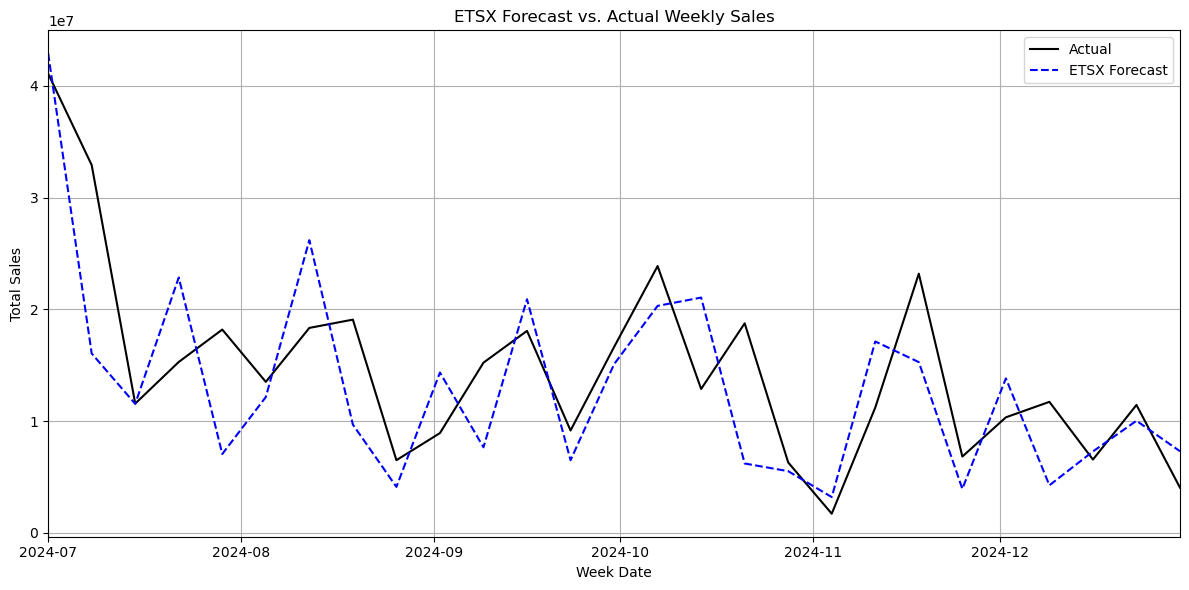

[I 2025-06-18 14:00:06,085] A new study created in memory with name: ARIMAX_tuning



Optimizing ARIMAX...


[I 2025-06-18 14:00:52,533] Trial 0 finished with value: 865.1513599031558 and parameters: {'p': 20, 'q': 50}. Best is trial 0 with value: 865.1513599031558.
[I 2025-06-18 14:01:20,092] Trial 1 finished with value: 858.9654834391482 and parameters: {'p': 39, 'q': 32}. Best is trial 1 with value: 858.9654834391482.
[I 2025-06-18 14:01:21,763] Trial 2 finished with value: 1430.3854628478487 and parameters: {'p': 9, 'q': 9}. Best is trial 1 with value: 858.9654834391482.
[I 2025-06-18 14:02:08,451] Trial 3 finished with value: 1077.9166874247292 and parameters: {'p': 4, 'q': 46}. Best is trial 1 with value: 858.9654834391482.
[I 2025-06-18 14:02:30,949] Trial 4 finished with value: 1088.3237997221593 and parameters: {'p': 32, 'q': 37}. Best is trial 1 with value: 858.9654834391482.
[I 2025-06-18 14:03:04,003] Trial 5 finished with value: 1079.700356202604 and parameters: {'p': 2, 'q': 51}. Best is trial 1 with value: 858.9654834391482.
[I 2025-06-18 14:03:39,229] Trial 6 finished with val


Best Parameters for ARIMAX:
{'p': 52, 'q': 2}
Best trial was at: 12

Evaluation Metrics for ARIMAX:
RMSE: 4834330.94
MAE: 4104631.02
MAPE: 40.85%


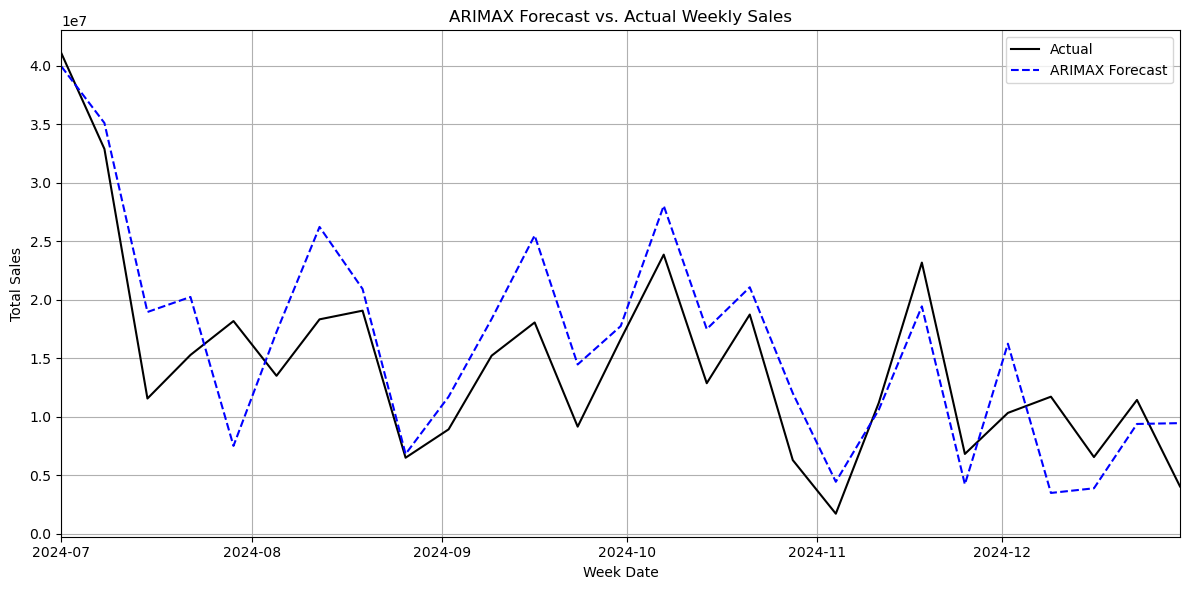

[I 2025-06-18 14:12:40,055] A new study created in memory with name: SARIMAX_tuning



Optimizing SARIMAX...


[I 2025-06-18 14:15:49,418] Trial 0 finished with value: 26777.626923887517 and parameters: {'p': 3, 'q': 7, 'P': 6, 'Q': 5}. Best is trial 0 with value: 26777.626923887517.
[I 2025-06-18 14:19:02,618] Trial 1 finished with value: 25179.97374143935 and parameters: {'p': 2, 'q': 2, 'P': 1, 'Q': 7}. Best is trial 1 with value: 25179.97374143935.
[I 2025-06-18 14:22:11,600] Trial 2 finished with value: 38575.85745594106 and parameters: {'p': 5, 'q': 5, 'P': 1, 'Q': 7}. Best is trial 1 with value: 25179.97374143935.
[I 2025-06-18 14:35:33,502] Trial 3 finished with value: 26515.457323793515 and parameters: {'p': 6, 'q': 2, 'P': 2, 'Q': 2}. Best is trial 1 with value: 25179.97374143935.



Best Parameters for SARIMAX:
{'p': 2, 'q': 2, 'P': 1, 'Q': 7}
Best trial was at: 1

Evaluation Metrics for SARIMAX:
RMSE: 5304369.36
MAE: 4064946.95
MAPE: 32.11%


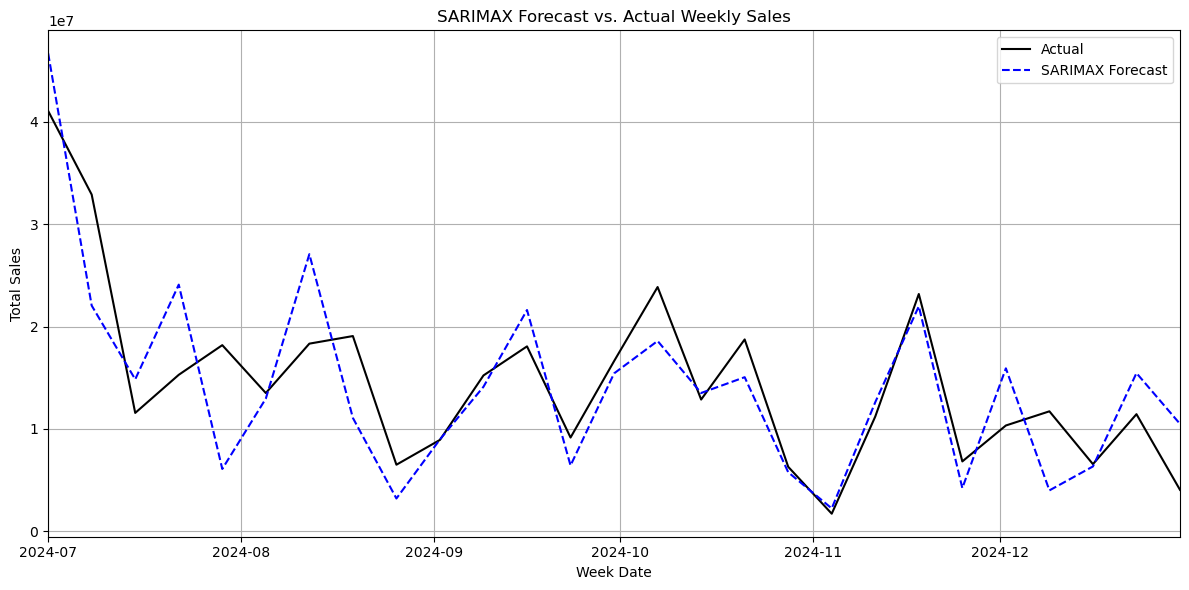

In [ ]:
# Run Optuna optimization for each model
for model_name, objective in models.items():
    print(f"\n{'='*50}\nOptimizing {model_name}...\n{'='*50}")
    study = optuna.create_study(
        study_name=f"{model_name}_tuning",
        direction='minimize',
        sampler=optuna.samplers.TPESampler(seed=42)
    )
    study.optimize(objective, n_trials=50, timeout=600)
    best_params[model_name] = study.best_params

    print(f"\nBest Parameters for {model_name}:")
    print(best_params[model_name])
    print("Best trial was at:", study.best_trial.number)

    # Train and forecast with best parameters
    if model_name == 'ARIMAX':
        model = ARIMA(
            train_y_boxcox,
            exog=train_exog_scaled,
            order=(best_params[model_name]['p'], 0, best_params[model_name]['q'])
        )
        fit = model.fit()
        forecast_boxcox = fit.forecast(steps=len(test_y), exog=test_exog_scaled)
        forecast = inv_boxcox(forecast_boxcox, boxcox_lambda) - 1
        forecasts[model_name] = forecast
        metrics_dict[model_name] = compute_metrics(test_y, forecast)

    elif model_name == 'SARIMAX':
        model = SARIMAX(
            train_y_boxcox,
            exog=train_exog_scaled,
            order=(best_params[model_name]['p'], 0, best_params[model_name]['q']),
            seasonal_order=(best_params[model_name]['P'], 1, best_params[model_name]['Q'], 52),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        fit = model.fit(disp=False)
        forecast_boxcox = fit.forecast(steps=len(test_y), exog=test_exog_scaled)
        forecast = inv_boxcox(forecast_boxcox, boxcox_lambda) - 1
        forecasts[model_name] = forecast
        metrics_dict[model_name] = compute_metrics(test_y, forecast)

    elif model_name == 'ETSX':
        ets_model = ETSModel(
            train_y_boxcox,
            error=best_params[model_name]['error'],
            trend=best_params[model_name]['trend'],
            damped_trend=best_params[model_name]['damped_trend'],
            seasonal=best_params[model_name]['seasonal'],
            seasonal_periods=52
        )
        ets_fit = ets_model.fit()
        train_residuals = train_y_boxcox - ets_fit.fittedvalues
        reg_model = LinearRegression()
        reg_model.fit(train_exog_scaled, train_residuals)
        test_ets_forecast = ets_fit.forecast(steps=len(test_y))
        test_reg_pred = reg_model.predict(test_exog_scaled)
        forecast_boxcox = test_ets_forecast + test_reg_pred
        forecast = inv_boxcox(forecast_boxcox, boxcox_lambda) - 1
        
        forecasts[model_name] = forecast
        metrics_dict[model_name] = compute_metrics(test_y, forecast)

    elif model_name == 'Prophet':
        model = Prophet(
            changepoint_prior_scale=best_params[model_name]['changepoint_prior_scale'],
            n_changepoints=best_params[model_name]['n_changepoints'],
            seasonality_prior_scale=best_params[model_name]['seasonality_prior_scale'],
            seasonality_mode=best_params[model_name]['seasonality_mode'],
            yearly_seasonality=True,
            weekly_seasonality=False,
            daily_seasonality=False
        )
        # Add U.S. holidays
        model.add_country_holidays(country_name='US')

        for col in exog_cols:
            model.add_regressor(col)
        model.fit(train_prophet)
        future = test_prophet[['ds'] + exog_cols]
        forecast = model.predict(future)
        forecast = forecast['yhat'].values
        forecasts[model_name] = forecast
        metrics_dict[model_name] = compute_metrics(test_y, forecast)

    elif model_name == 'NeuralProphet':
        # Prepare model with best parameters
        n_ar_layers = best_params[model_name]['n_ar_layers']
        ar_layer_size = best_params[model_name]['ar_layer_size']
        ar_layers = [ar_layer_size] * n_ar_layers
        model_params = best_params[model_name].copy()
        model_params.pop('n_ar_layers')
        model_params.pop('ar_layer_size')
        model_params['ar_layers'] = ar_layers
        model_params['yearly_seasonality'] = True
        model_params['weekly_seasonality'] = False
        model_params['daily_seasonality'] = False


        model = NeuralProphet(**model_params)
        
        # Add U.S. holidays
        model.add_country_holidays(country_name='US')

        for col in exog_cols:
            model.add_future_regressor(col)
        n_lags = best_params[model_name]['n_lags']

        # Prepare combined dataframe with extra date
        # needs hist_df as the model require to have context from historical data to get lags
        hist_df = train_np.tail(n_lags)[['ds', 'y'] + exog_cols]
        test_np_copy = test_np[['ds', 'y'] + exog_cols].copy()
        # Add one extra week as NP will not predict the last week
        last_date = test_np_copy['ds'].iloc[-1]
        if last_date not in test_np_copy['ds'].values:
            extra_row = test_np_copy.iloc[-1:].copy()
            extra_row['ds'] = last_date
            extra_row['y'] = np.nan
            for col in exog_cols:
                extra_row[col] = extra_row[col].iloc[0]
            test_np_copy = pd.concat([test_np_copy, extra_row], ignore_index=True)
        next_date = last_date + pd.Timedelta(weeks=1) 
        extra_row = test_np_copy.iloc[-1:].copy()
        extra_row['ds'] = next_date
        extra_row['y'] = np.nan
        for col in exog_cols:
            extra_row[col] = test_np_copy[col].iloc[-1]
        test_np_copy = pd.concat([test_np_copy, extra_row], ignore_index=True)

        combined_df = pd.concat([hist_df, test_np_copy], ignore_index=True)
        combined_df['ds'] = pd.to_datetime(combined_df['ds'])
        combined_df = combined_df.drop_duplicates(subset='ds', keep='last').reset_index(drop=True)
        # Fit and predict
        model.fit(train_np, freq='W')
        forecast_df = model.predict(combined_df)
        forecast_df = forecast_df[forecast_df['ds'].isin(test_df.index)]
        forecast = forecast_df['yhat1'].values
        forecasts[model_name] = forecast

        # Compute metrics
        metrics_dict[model_name] = compute_metrics(test_y, forecast)

    # Print evaluation metrics
    rmse, mae, mape = metrics_dict[model_name]
    print(f"\nEvaluation Metrics for {model_name}:")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"MAPE: {mape:.2f}%")

    # Plot forecast
    plt.figure(figsize=(12, 6))
    plt.plot(test_y.index, test_y, label='Actual', color='black')
    plt.plot(test_y.index, forecasts[model_name], label=f'{model_name} Forecast', linestyle='--', color='blue')
    plt.legend()
    plt.title(f'{model_name} Forecast vs. Actual Weekly Sales')
    plt.xlabel('Week Date')
    plt.ylabel('Total Sales')
    plt.grid(True)
    plt.xlim(pd.Timestamp('2024-07-01'), test_y.index[-1])
    plt.tight_layout()
    plt.show()

In [15]:
best_params 

{'NeuralProphet': {'n_ar_layers': 3,
  'ar_layer_size': 256,
  'n_lags': 14,
  'learning_rate': 0.00464539026430501,
  'seasonality_mode': 'additive',
  'n_changepoints': 22,
  'seasonality_reg': 0.30209849338902767,
  'ar_reg': 0.010664245304051481,
  'trend_reg': 0.3406899592201038},
 'Prophet': {'changepoint_prior_scale': 0.9658704587603621,
  'n_changepoints': 16,
  'seasonality_prior_scale': 7.24447121385322,
  'seasonality_mode': 'multiplicative'},
 'ETSX': {'error': 'mul',
  'trend': 'add',
  'damped_trend': True,
  'seasonal': 'mul'},
 'ARIMAX': {'p': 52, 'q': 2},
 'SARIMAX': {'p': 2, 'q': 2, 'P': 1, 'Q': 7}}

In [19]:
forecasts

{'Baseline': 2024-07-01    2.892142e+07
 2024-07-08    2.927721e+07
 2024-07-15    1.435119e+07
 2024-07-22    2.395184e+07
 2024-07-29    9.447254e+06
 2024-08-05    2.128635e+07
 2024-08-12    2.018154e+07
 2024-08-19    1.896807e+07
 2024-08-26    9.647795e+06
 2024-09-02    8.173320e+06
 2024-09-09    1.669777e+07
 2024-09-16    2.135950e+07
 2024-09-23    1.859354e+07
 2024-09-30    1.002776e+07
 2024-10-07    2.253345e+07
 2024-10-14    1.743632e+07
 2024-10-21    2.520742e+07
 2024-10-28    1.220944e+07
 2024-11-04    8.294070e+06
 2024-11-11    8.647605e+06
 2024-11-18    2.570459e+07
 2024-11-25    7.052007e+06
 2024-12-02    1.470805e+07
 2024-12-09    4.865283e+06
 2024-12-16    9.265248e+06
 2024-12-23    1.284134e+07
 2024-12-30    1.613183e+07
 Freq: W-MON, Name: predicted_mean, dtype: float64,
 'NeuralProphet': array([35174472., 35769264., 13601446., 20013990., 18238824., 14952218.,
        22053028., 14643363.,  5950793.,  9729839., 13282902., 19375350.,
        1239817

In [21]:
def smape(actual, forecast):
    actual = np.array(actual)
    forecast = np.array(forecast)
    denominator = (np.abs(actual) + np.abs(forecast)) / 2.0
    diff = np.abs(actual - forecast)
    # Avoid division by zero
    smape_vals = np.where(denominator == 0, 0, diff / denominator)
    return np.mean(smape_vals) * 100

smape_dict = {}
for model_name, forecast in forecasts.items():
    smape_dict[model_name] = smape(test_y, forecast)

smape_df = pd.DataFrame.from_dict(smape_dict, orient='index', columns=['SMAPE'])
print(smape_df.round(2))

               SMAPE
Baseline       37.20
NeuralProphet  31.35
Prophet        35.89
ETSX           40.98
ARIMAX         35.45
SARIMAX        32.13


In [ ]:
# Add SMAPE to metrics_dict for each model, as MAPE was accidentally printed instead of sMAPE
for model_name, forecast in forecasts.items():
    smape_value = smape(test_y, forecast)
    if model_name in metrics_dict:
        # metrics_dict[model_name] is a tuple (rmse, mae, mape)
        metrics_dict[model_name] = (*metrics_dict[model_name], smape_value)
    else:
        # If not present, just store SMAPE
        metrics_dict[model_name] = (None, None, None, smape_value)

In [28]:
metrics_dict

{'Baseline': (5827717.502008796,
  4739494.366980097,
  55.820925189305825,
  37.19516539476404),
 'NeuralProphet': (4826176.019673751,
  3900347.6666666665,
  54.71577923151487,
  31.35444113581396),
 'Prophet': (5443770.962101408,
  4627710.585067711,
  40.70893006243029,
  35.891852286243015),
 'ETSX': (6543943.909278097,
  5110059.036515457,
  38.67290731513322,
  40.97688904385575),
 'ARIMAX': (4834330.942817278,
  4104631.019872529,
  40.853819855877745,
  35.44547689336248),
 'SARIMAX': (5304369.361439753,
  4064946.9495939603,
  32.11187157304642,
  32.12795706848552)}

In [ ]:
# FINAL metrics in a table
metrics_summary = pd.DataFrame(metrics_dict, index=['RMSE', 'MAE', 'MAPE', 'sMAPE']).T
print("\nSummary of Evaluation Metrics:")
print(metrics_summary.round(2))


Summary of Evaluation Metrics:
                     RMSE         MAE   MAPE  sMAPE
Baseline       5827717.50  4739494.37  55.82  37.20
NeuralProphet  4826176.02  3900347.67  54.72  31.35
Prophet        5443770.96  4627710.59  40.71  35.89
ETSX           6543943.91  5110059.04  38.67  40.98
ARIMAX         4834330.94  4104631.02  40.85  35.45
SARIMAX        5304369.36  4064946.95  32.11  32.13


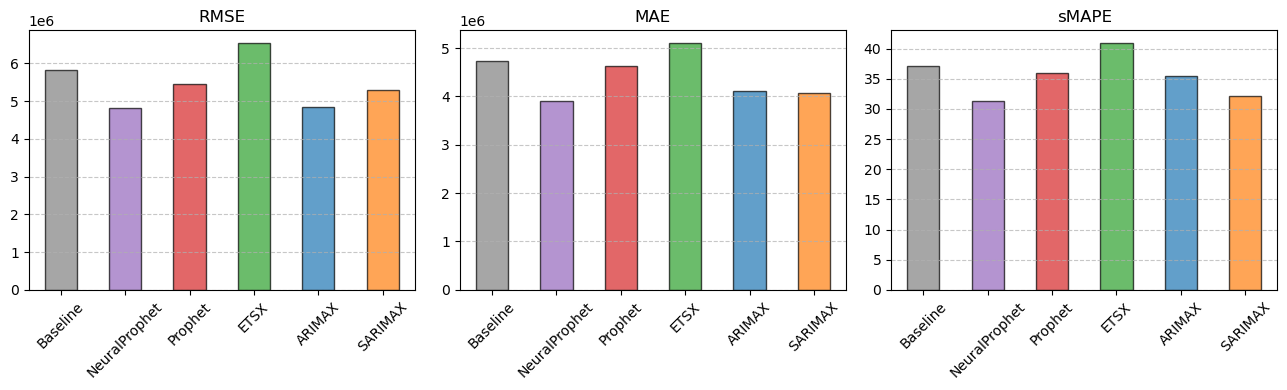

In [ ]:
# ONLY PLOT RMSE, MAE, SMAPE

metrics_to_plot = ['RMSE', 'MAE', 'sMAPE']
model_colors = {
    'baseline': "#ffd34d",
    'ARIMAX': '#1f77b4',
    'SARIMAX': '#ff7f0e',
    'ETSX': '#2ca02c',
    'Prophet': '#d62728',
    'NeuralProphet': '#9467bd'
}

fig, axes = plt.subplots(1, 3, figsize=(13, 4))
axes = axes.flatten()

for idx, metric in enumerate(metrics_to_plot):
    color_list = [model_colors.get(model, 'gray') for model in metrics_summary.index]
    metrics_summary[metric].plot(
        kind='bar',
        ax=axes[idx],
        color=color_list,
        edgecolor='black',
        alpha=0.7
    )
    axes[idx].set_title(metric)
    axes[idx].grid(axis='y', linestyle='--', alpha=0.7)
    # Make x-axis tick labels horizontal
    for label in axes[idx].get_xticklabels():
        label.set_rotation(45)

# Hide any unused subplots
for j in range(len(metrics_to_plot), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

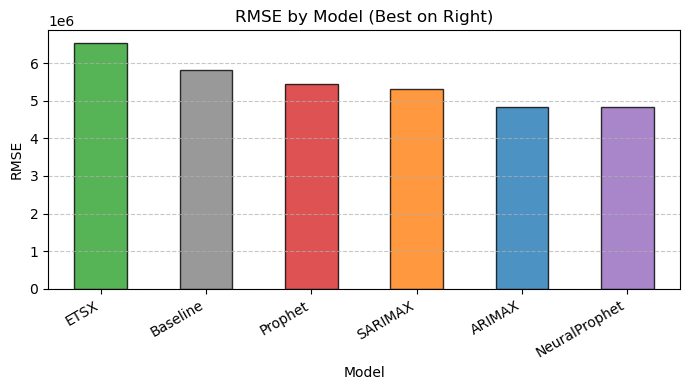

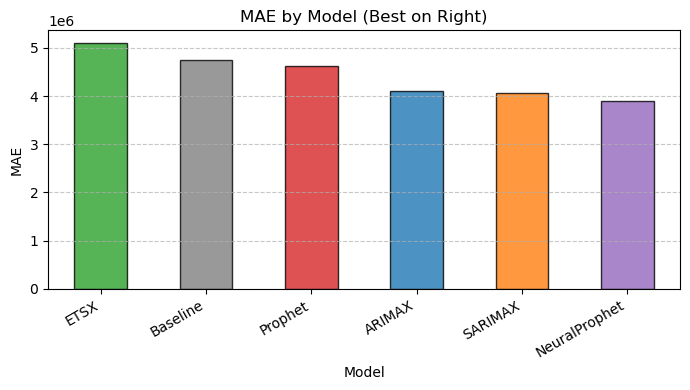

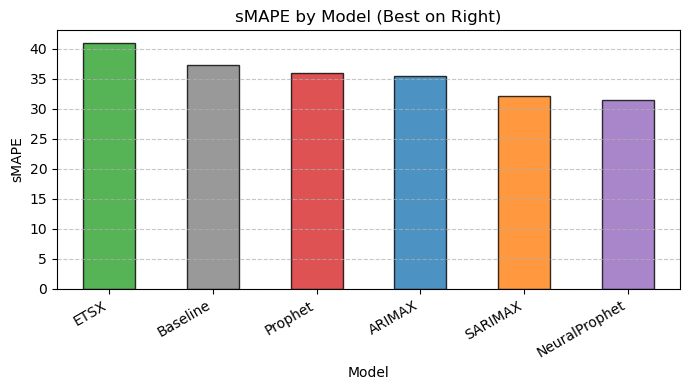

In [44]:
# Prepare metrics for plotting
metrics_to_plot = ['RMSE', 'MAE', 'sMAPE']
model_colors = {
    'baseline': "#ffd34d",
    'ARIMAX': '#1f77b4',
    'SARIMAX': '#ff7f0e',
    'ETSX': '#2ca02c',
    'Prophet': '#d62728',
    'NeuralProphet': '#9467bd'
}

for metric in metrics_to_plot:
    # Sort so that the highest is on the left, lowest on the right
    sorted_metrics = metrics_summary[metric].sort_values(ascending=False)
    color_list = [model_colors.get(model, 'gray') for model in sorted_metrics.index]
    plt.figure(figsize=(7, 4))
    sorted_metrics.plot(
        kind='bar',
        color=color_list,
        edgecolor='black',
        alpha=0.8
    )
    plt.title(f'{metric} by Model (Best on Right)')
    plt.xlabel('Model')
    plt.ylabel(metric)
    plt.xticks(rotation=30, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

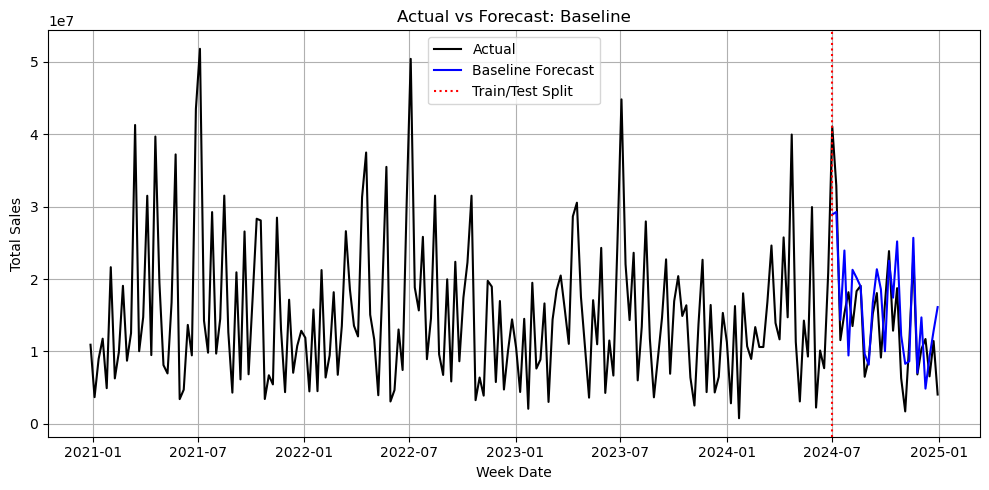

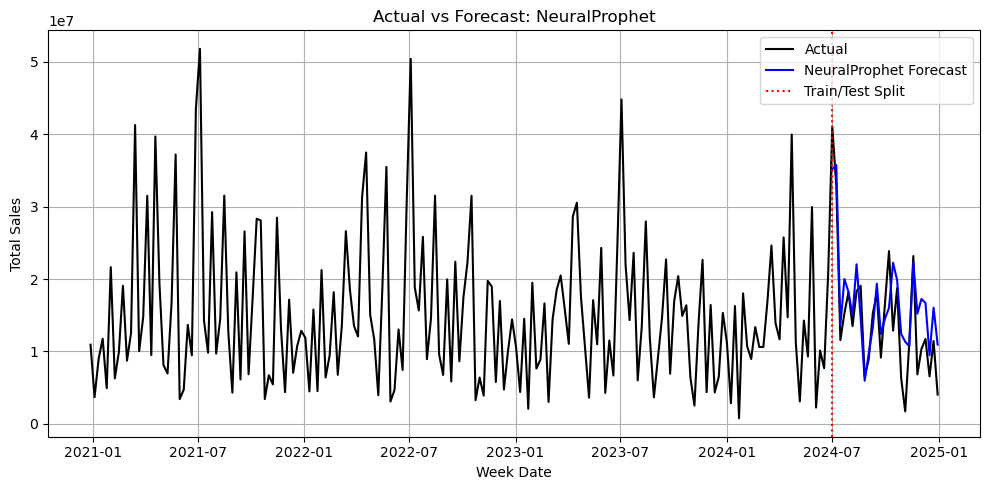

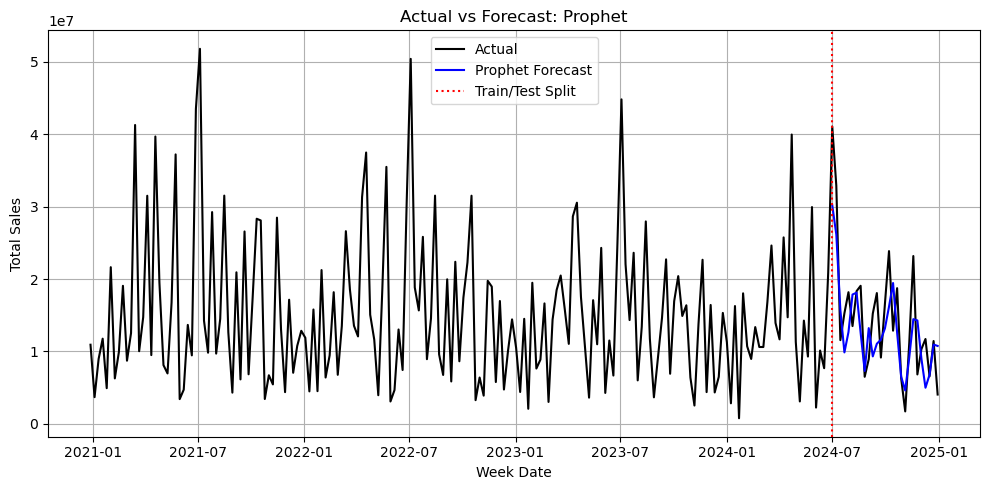

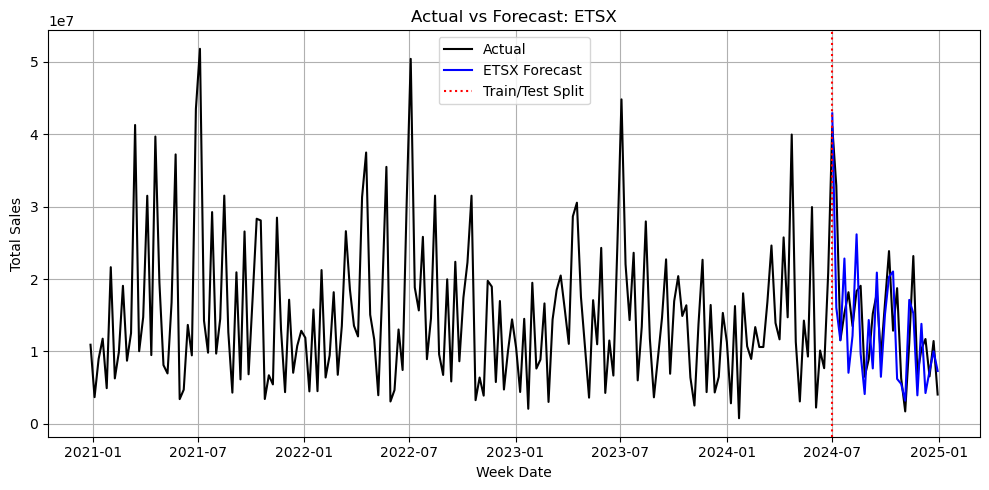

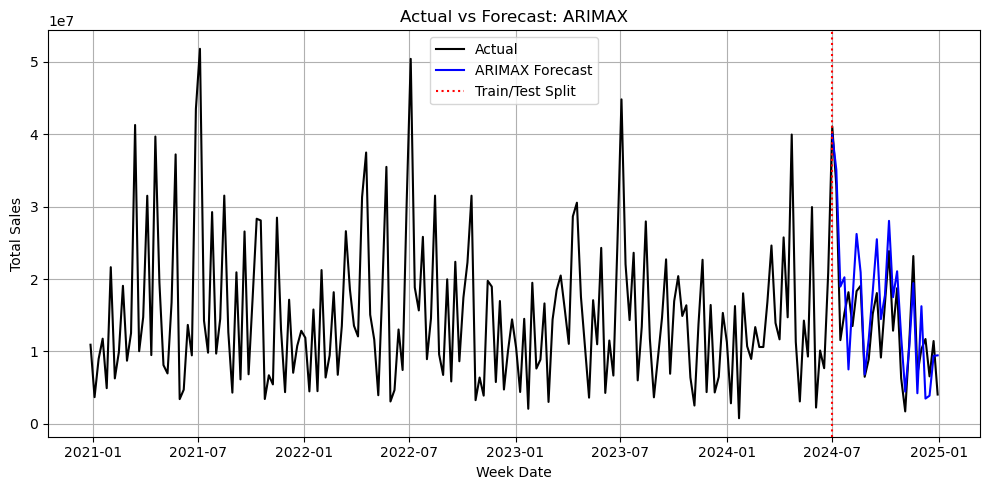

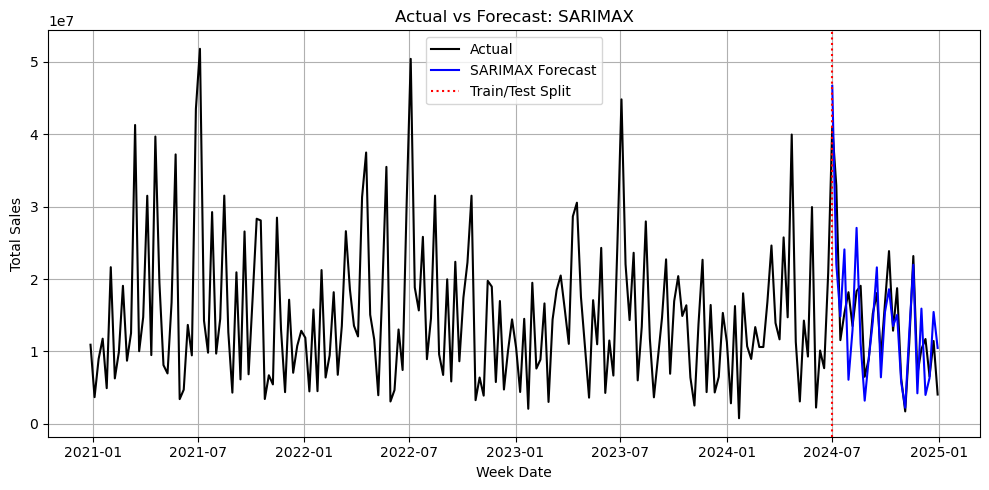

In [85]:
full_actuals = pd.concat([train_y, test_y])
split_date = pd.to_datetime('2024-07-01')

for model_name, forecast in forecasts.items():
    plt.figure(figsize=(10,5))
    
    # Plot actuals (train + test)
    plt.plot(full_actuals.index, full_actuals, label='Actual', color='black')
    
    # Plot forecast (test period only)
    plt.plot(test_y.index, forecast, label=f'{model_name} Forecast',
             color='blue')
    
    # Vertical line to indicate train/test split
    plt.axvline(x=split_date, color='red', linestyle=':', linewidth=1.5, label='Train/Test Split')
    
    plt.title(f'Actual vs Forecast: {model_name}')
    plt.xlabel('Week Date')
    plt.ylabel('Total Sales')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

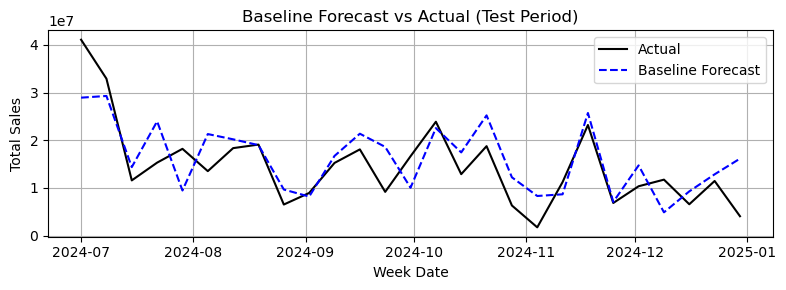

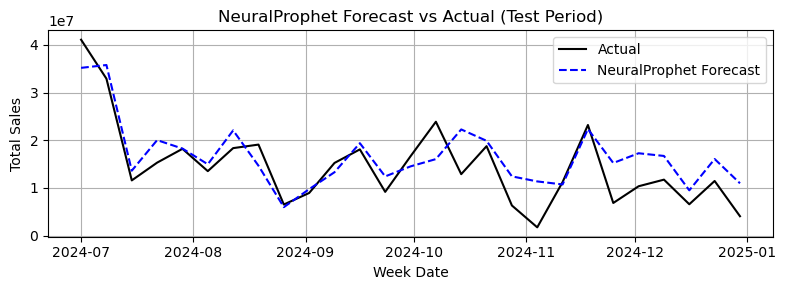

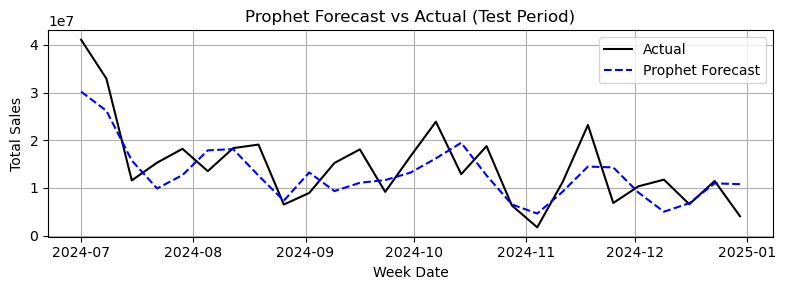

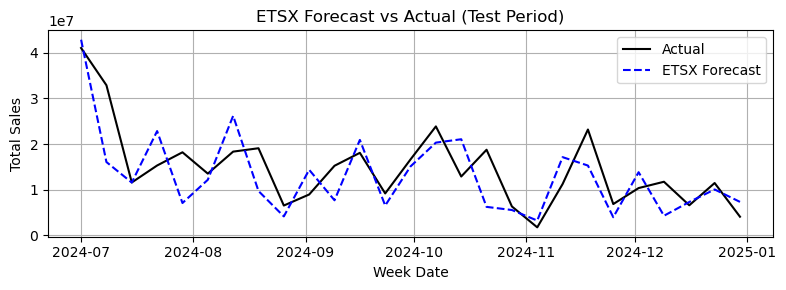

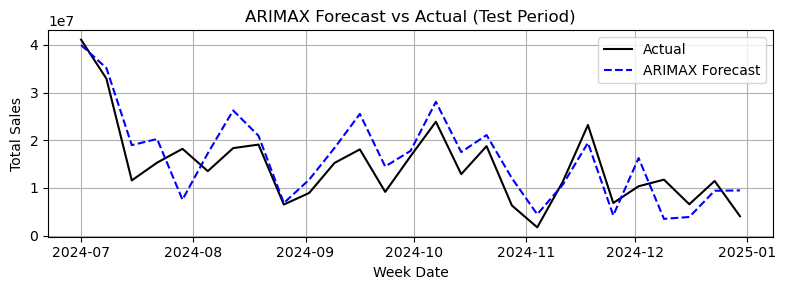

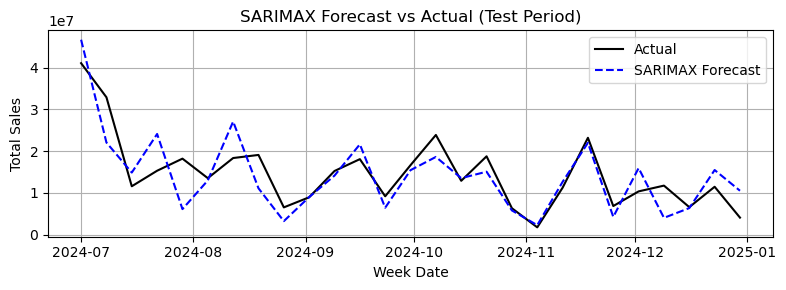

In [40]:
for model_name, forecast in forecasts.items():
    plt.figure(figsize=(8, 3))
    plt.plot(test_y.index, test_y.values, label='Actual', color='black')
    plt.plot(test_y.index, forecast, label=f'{model_name} Forecast', linestyle='--', color = 'blue')
    plt.title(f'{model_name} Forecast vs Actual (Test Period)')
    plt.xlabel('Week Date')
    plt.ylabel('Total Sales')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

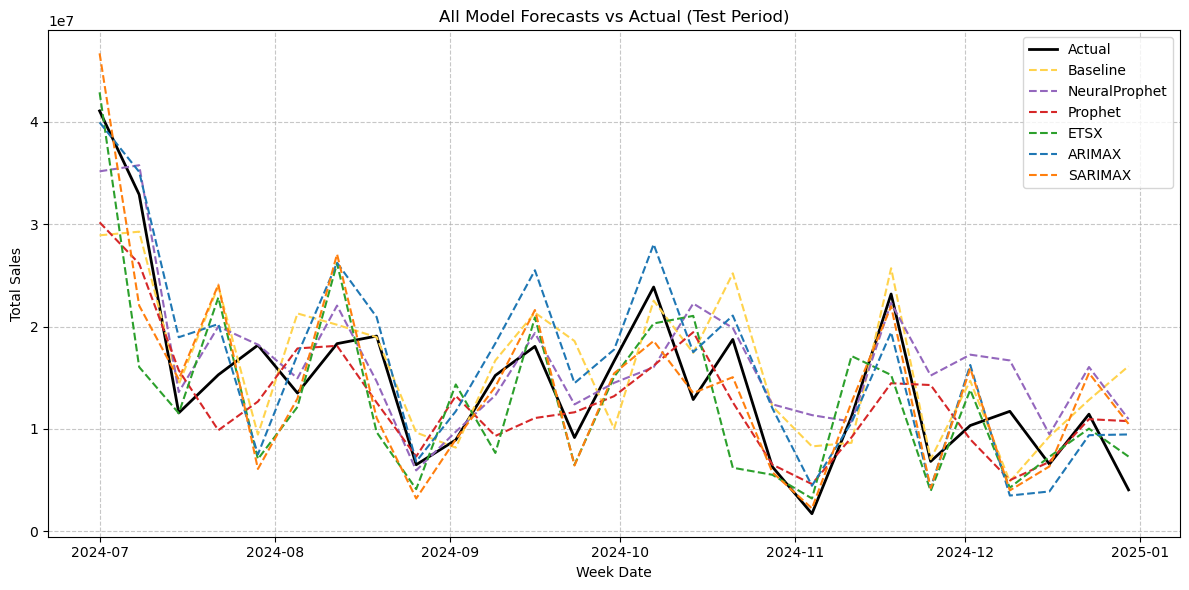

In [86]:
plt.figure(figsize=(12, 6))
plt.plot(test_y.index, test_y.values, label='Actual', color='black', linewidth=2)

colors = {
    'Baseline': '#ffd34d',
    'ARIMAX': '#1f77b4',
    'SARIMAX': '#ff7f0e',
    'ETSX': '#2ca02c',
    'Prophet': '#d62728',
    'NeuralProphet': '#9467bd'
}

for model_name, forecast in forecasts.items():
    plt.plot(test_y.index, forecast, label=model_name, linestyle='--', color=colors.get(model_name, None))

plt.title('All Model Forecasts vs Actual (Test Period)')
plt.xlabel('Week Date')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()